# AFM SINDy and AIC analysis for all clusters assuming no contact constraints

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from pysindy.utils import lorenz, lorenz_control, enzyme
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import pysindy as ps
import cvxpy
import math
import pandas as pd

# Define the directory path where the notebook is located
directory_path = "/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository/"

# Run the target notebook using the %run magic command
# Note: This only works inside Jupyter Notebook or IPython
%run $directory_path/AFM_SINDy_algorithm_functions.ipynb

# Equation of motion of a cantilever beam using a DMT Model

Here, the idea is to be able to simulate the cantilever with a DMT model. The non-smooth equations are of the form:

\begin{equation}
\text{Attractive Eq.} \begin{cases}\ddot{\tilde{q_1}}+D_1^{\text{att}}\dot{\tilde{q_1}}+K_1\dot{\tilde{q_1}} = -C_1-F_{ts,1}(\bar{z})+B_1 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau} \\ \ddot{\tilde{q_2}}+D_2^{\text{att}}\dot{\tilde{q_2}}+K_2\dot{\tilde{q_2}} = -C_2-F_{ts,2}(\bar{z})+B_2 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau}\end{cases}
\end{equation}

\begin{equation}
\text{Repulsive Eq.} \begin{cases}\ddot{\tilde{q_1}}+D_1^{\text{rep}}\dot{\tilde{q_1}}+K_1\dot{\tilde{q_1}} = -C_1-F_{ts,1}(\bar{z})+B_1 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau} \\ \ddot{\tilde{q_2}}+D_2^{\text{rep}}\dot{\tilde{q_2}}+K_2\dot{\tilde{q_2}} = -C_2-F_{ts,2}(\bar{z})+B_2 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau}\end{cases}
\end{equation}

# Equation of motion of a cantilever beam using a DMT + Viscoelastic damping

Here, the idea is to be able to simulate the cantilever with a DMT model with Viscoelastic damping. The equations would be simulated in their phase space form as follows:

\begin{equation}
\text{Attractive Eq.} \begin{cases}\dot{\eta_1}=\eta_2 \\ \dot{\eta_2}= -d_1\eta_2-\eta_1-C_1-\dfrac{C_1}{{(1-\eta_1)}^{2}}+B_1\bar{\Omega}^{2} \bar{y}\sin{\phi}\\ \dot{\phi}=1\end{cases}
\end{equation}

\begin{equation}
\text{Repulsive Eq.} \begin{cases}\dot{\eta_1}=\eta_2 \\ \dot{\eta_2}=-d_2 \eta_2 -\eta_1 -C_1-C_2(a_0-[1-\eta_1])^{1.5}-C_3(\sqrt{a_0-[1-\eta_1]}\cdot \eta_2)-\dfrac{C_4}{a_0^2}+\bar{y}\bar{\Omega}^{2}B_1\sin{\phi} \\ \dot{\phi}=1 \end{cases}
\end{equation}

In [2]:
def AFM_w_DMT_viscoelastic_damp(t, y, a0, d1, d2, C1, C2, C3, B1, y_bar, forcing_freq):
    
    eta_1, eta_2, phase = y

    deta1dt = eta_2

    if 1-eta_1 <= a0: 
        deta2dt = (-d2*eta_2) - eta_1 - C1 - (C1/a0**2) - C2* (a0-(1 - eta_1))**1.5 - C3*(((a0-(1 - eta_1))**(0.5))*eta_2) + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase) #Repulsive regime
    else: 
        deta2dt = (-d1*eta_2) - eta_1 - C1 - (C1/(1-eta_1)**2) + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase)  #Attractive regime

    dphase_dt = forcing_freq

    return [deta1dt, deta2dt,dphase_dt] 

In [ ]:
C1 = -1.27462*10**(-6)
C2 =  4.63118
C3 = -4e-1 
B1 = 1.56598
a0 = 0.0132626 
d1 = 0.0034 / 2
d2 = 4.057 / 2
forcing_freq = 1.002 
y_bar = 0.05585 
F_act = B1*(forcing_freq**2)*y_bar 

dt = 0.01 
t_train_DMT = np.arange(0, 1000, dt) #time until 1000 steps
init_cond_DMT = [0.0, 0.0, 0.0] # Initial conditions for position and velocity respectibly
t_train_span_DMT = (t_train_DMT[0], t_train_DMT[-1])  # Time span for the simulation

#Solve initial value problem
AFM_DMT_ivp = solve_ivp(AFM_w_DMT_viscoelastic_damp, t_train_span_DMT, init_cond_DMT, t_eval=t_train_DMT, args=(a0, d1, d2, C1, C2, C3, B1, y_bar, forcing_freq), rtol=1e-6, atol=1e-8, method = 'RK45', dense_output=True)  #`atol`. Default values are 1e-3 for `rtol` and 1e-6 for `atol`.
x_train_DMT = AFM_DMT_ivp.y.T
t_train_DMT_ivp = AFM_DMT_ivp.t

#### Cantilever beam data:

Define the parameters for the cantilever to be simualted

In [4]:
eta_star = 8.88249 #in [nm] for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)
w_0_cant = 2*np.pi*11.086e3 #first natural frequency of cantilever in [rad/s]
Q_factor = 100 #In air for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)

### Generate multiple trajectories for validation

In [5]:
x_train_DMT_mult_traj, init_cond_list = generate_different_trajectories(dynamical_system= AFM_w_DMT_viscoelastic_damp, t_train = t_train_DMT, DOF = 3,
                                                       num_trajectories = 3, noisy_trajectories = False, parameters = (a0,d1,d2,C1,C2,C3, B1,y_bar,forcing_freq), 
                                                       noise_level = None, init_cond_range = [(-0.5, 0.5), (-0.25, 0.25), (0,2*np.pi)])

Generating Trajectories: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


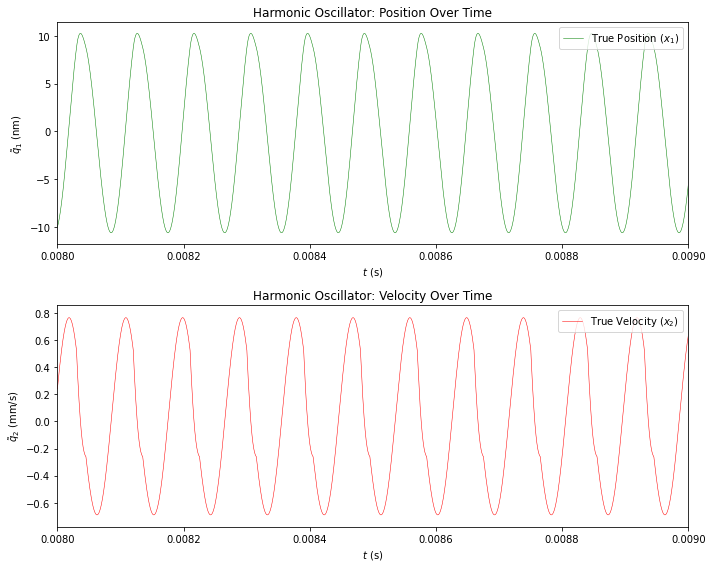

In [6]:
# Select the signal to plot:
signal = x_train_DMT_mult_traj[1] #one of the multiple generated trajectories
time = t_train_DMT

#Calculations to set the units back on the equation results
x_train_true_disp, true_t_train_DMT = get_true_AFM_displacement(signal[:,0], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel, true_t_train_DMT = get_true_AFM_velocity(signal[:,1], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel = x_train_true_vel*(1e-9)*(1000) #for velcolity in [mm/s]

# Setup the figure and subplots
set_plot_style()
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Column

# First subplot for Position
axs[0].plot(true_t_train_DMT, x_train_true_disp, linewidth=0.5, label='True Position ($x_1$)', color = 'g')
axs[0].set_xlabel(r'$t$ (s)')
axs[0].set_ylabel(r'$\tilde{q}_1$ (nm)')
axs[0].legend(loc = 'upper right')
axs[0].set_title('Harmonic Oscillator: Position Over Time')
axs[0].set_xlim([0.008, 0.009])

# Second subplot for Velocity
axs[1].plot(true_t_train_DMT, x_train_true_vel, linewidth=0.5, label='True Velocity ($x_2$)', color = 'r')
axs[1].set_xlabel(r'$t$ (s)')
axs[1].set_ylabel(r'$\tilde{q}_2$ (mm/s)')
axs[1].legend(loc = 'upper right')
axs[1].set_title('Harmonic Oscillator: Velocity Over Time')
axs[1].set_xlim([0.008, 0.009])
plt.tight_layout() 
file_name = 'simple_oscillator_2_1st try'
# plt.savefig(f't_{file_name}.jpg', dpi=300, bbox_inches='tight') #to save the image if needed

## Creation of trajectory Clusters

### Placing Cluster Centers

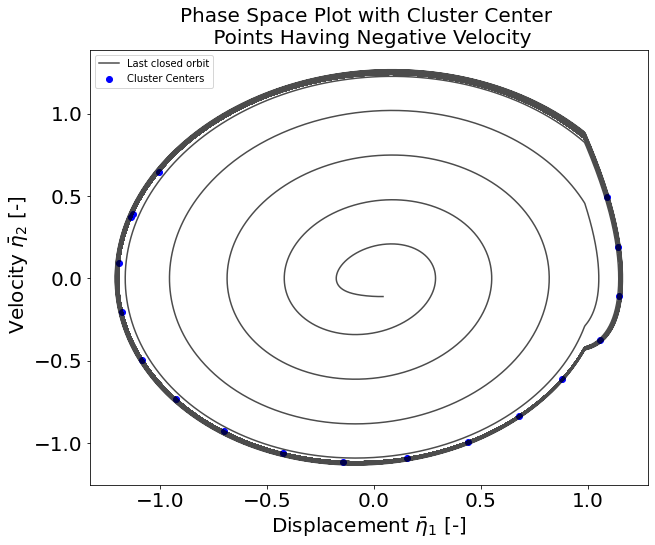

18


In [7]:
mult_traj_cluster_centers_x, mult_traj_cluster_centers_y = define_cluster_centers(x_train_mult_trajectories = x_train_DMT_mult_traj, num_points_high_res=800, 
                                                              sub_sample_val=30, filter_vel_max_val = 0.7, index_to_plot = 0, centers_loc = 3,
                                                              plot_file_name = None, plot=True, save_plot=False, multiple_init_cond =True)

print(len(mult_traj_cluster_centers_x[0]))

## Filter extra points from clustering

In [8]:
# Flatten the lists and combine each corresponding x and y into a single list of tuples
combined_x = np.hstack(mult_traj_cluster_centers_x)
combined_y = np.hstack(mult_traj_cluster_centers_y)

# Filter points
filtered_x, filtered_y = filter_close_points(combined_x, combined_y)

### Generating cluster from cluster centers

In [9]:
mult_traj_clusters_sections, mult_traj_clusters_dots_list = generate_fixed_clusters_from_centers(cluster_size= 18, x_train_mult_trajectories = x_train_DMT_mult_traj[0],
                                                                                                 KNN_neighbors_num = 400, KNN_radius = 1, 
                                                                                                 mult_traj_cluster_centers_x = filtered_x,
                                                                                                 mult_traj_cluster_centers_y = filtered_y,
                                                                                                 multiple_init_cond = False)

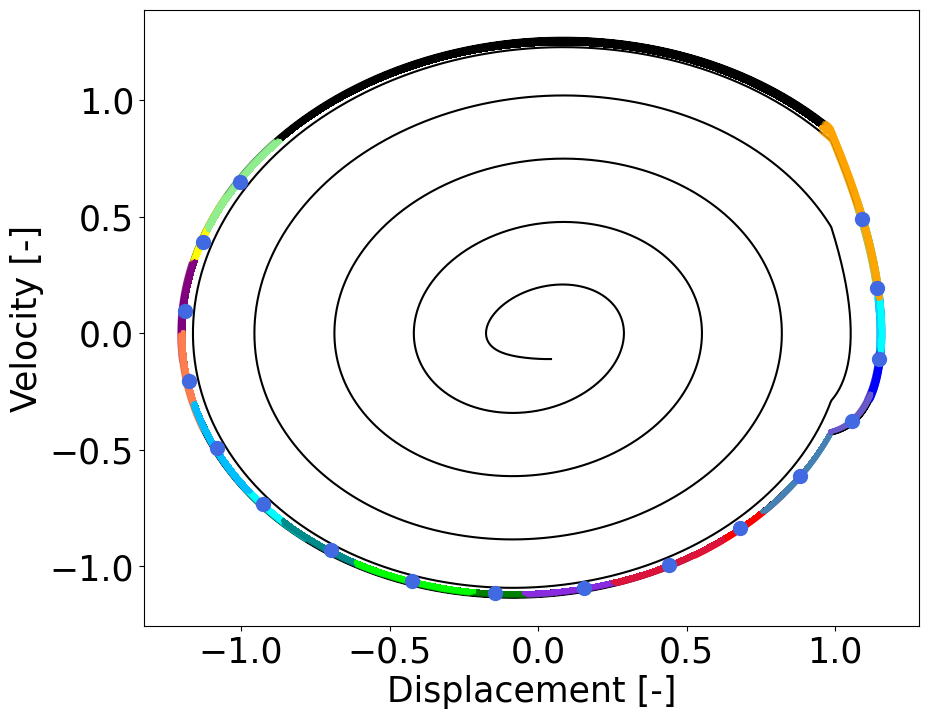

In [10]:
from itertools import cycle
set_plot_style()

traject = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# plt.axvline(x=(1-a0), color='black', linestyle='--', label=f'Intermolecular Dist')
axs.plot(x_train_DMT_mult_traj[traject][:,0], x_train_DMT_mult_traj[traject][:,1], color = 'black', linewidth=1.5, alpha = 1, zorder=1)

colors = cycle(['yellow', 'blue', 'red', 'green', 'cyan', 'purple', 'aqua', 'steelblue', 'blueviolet', 'darkcyan', 'coral',
    'lightgreen', 'orange', 'slateblue', 'crimson', 'lime', 'deepskyblue'
])

for cluster in range(len(mult_traj_clusters_sections[traject])):
    current_color = next(colors)  # Get the next color from the cycle
    for cluster_dot in range(len(mult_traj_clusters_sections[traject][cluster])):
        axs.plot(mult_traj_clusters_sections[traject][cluster][cluster_dot][:,0], mult_traj_clusters_sections[traject][cluster][cluster_dot][:,1], color = current_color, linewidth=2.5, alpha =0.6, zorder=2)
    axs.plot(mult_traj_cluster_centers_x[traject][cluster], mult_traj_cluster_centers_y[traject][cluster], '.', color = 'royalblue', markersize = 20, zorder=3)

axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)

# Customizing tick labels size
axs.tick_params(axis='both', which='major', labelsize=25)  # Customize the font size of the tick labels
axs.tick_params(axis='both', which='major', labelsize=25)  # Customize the font size of the tick label

# Saving the figure with a transparent background
# plt.savefig('Fig_1_DMT_synthetic_data_phase_space_mult_clusters_w_centers_no_symbols_17_clusters_XX.png', transparent=True, dpi=300, bbox_inches='tight')

# Import trained models in clusters

In [11]:
found_models_df = pd.DataFrame(columns=['Candidate Model', 'Model Type', 'Serial No.', 'Cluster No.', 'Lambda', 'Nu', 'Parsimony'])
found_models_df = import_trained_models_from_folder_to_dataframe(folder_path = '/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository',
                                                                 folder_name = 'attractive_model_with_viscoelastic_terms_17_clusters',
                                                                 new_dataframe = found_models_df, number_of_parsimony_eq = 2)

### Divide data in Dataframe accourding to their Clusters

In [12]:
# Filter rows where 'Cluster No.' is 0
found_models_C0_df = found_models_df[found_models_df['Cluster No.'] == '0'].copy()

# Filter rows where 'Cluster No.' is 1
found_models_C1_df = found_models_df[found_models_df['Cluster No.'] == '1'].copy()

# Filter rows where 'Cluster No.' is 2
found_models_C2_df = found_models_df[found_models_df['Cluster No.'] == '2'].copy()

# Filter rows where 'Cluster No.' is 3
found_models_C3_df = found_models_df[found_models_df['Cluster No.'] == '3'].copy()

# Filter rows where 'Cluster No.' is 4
found_models_C4_df = found_models_df[found_models_df['Cluster No.'] == '4'].copy()

# Filter rows where 'Cluster No.' is 5
found_models_C5_df = found_models_df[found_models_df['Cluster No.'] == '5'].copy()

# Filter rows where 'Cluster No.' is 6
found_models_C6_df = found_models_df[found_models_df['Cluster No.'] == '6'].copy()

# Filter rows where 'Cluster No.' is 7
found_models_C7_df = found_models_df[found_models_df['Cluster No.'] == '7'].copy()

# Filter rows where 'Cluster No.' is 8
found_models_C8_df = found_models_df[found_models_df['Cluster No.'] == '8'].copy()

# Filter rows where 'Cluster No.' is 9
found_models_C9_df = found_models_df[found_models_df['Cluster No.'] == '9'].copy()

# Filter rows where 'Cluster No.' is 10
found_models_C10_df = found_models_df[found_models_df['Cluster No.'] == '10'].copy()

# Filter rows where 'Cluster No.' is 11
found_models_C11_df = found_models_df[found_models_df['Cluster No.'] == '11'].copy()

# Filter rows where 'Cluster No.' is 12
found_models_C12_df = found_models_df[found_models_df['Cluster No.'] == '12'].copy()

# Filter rows where 'Cluster No.' is 13
found_models_C13_df = found_models_df[found_models_df['Cluster No.'] == '13'].copy()

# Filter rows where 'Cluster No.' is 14
found_models_C14_df = found_models_df[found_models_df['Cluster No.'] == '14'].copy()

# Filter rows where 'Cluster No.' is 15
found_models_C15_df = found_models_df[found_models_df['Cluster No.'] == '15'].copy()

# Filter rows where 'Cluster No.' is 16
found_models_C16_df = found_models_df[found_models_df['Cluster No.'] == '16'].copy()

# Filter rows where 'Cluster No.' is 17
found_models_C17_df = found_models_df[found_models_df['Cluster No.'] == '17'].copy()

## Analysis for Cluster No. 0

In [13]:
found_models_C0_df = mark_unique_models_in_dataframe(found_models_C0_df)

# Now filter unique models:
unique_models_C0_df = found_models_C0_df[found_models_C0_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C0_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



### Checking repeated models

In [14]:
repeated_models_C0_df = found_models_C0_df[~found_models_C0_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C0_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within one cluster: Cluster 0

In [15]:
unique_models_to_analyze = unique_models_C0_df
analyzed_cluster = 0

simulated_information_C0, error_information_C0, AIC_models_in_cluster_C0 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C0 = get_relative_AIC_c_score(AIC_models_in_cluster_C0)

unique_models_C0_df['Delta_AIC_c'] = rel_AIC_c_lst_C0

Processing models: 100%|██████████| 100/100 [00:34<00:00,  2.91model/s]


## Best models within Cluster

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model.

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
pd.set_option('display.max_rows', None)
best_rel_AIC_c_C0_df = unique_models_C0_df[unique_models_C0_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C0_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  04-02-25-045-0           0         6  1.6681005372000593e-05   

                   Nu  Delta_AIC_c  
0  0.0774263682681127          0.0

## Simulation of one of these candidate models for cluster 0

rms was: 3.4098207416658406
switch_ind was: 201

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.000788294 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.005384321 (1-e1)^-2 + 0.012356593 (1-e1)^-3
(phase)' = 1.000000000 1



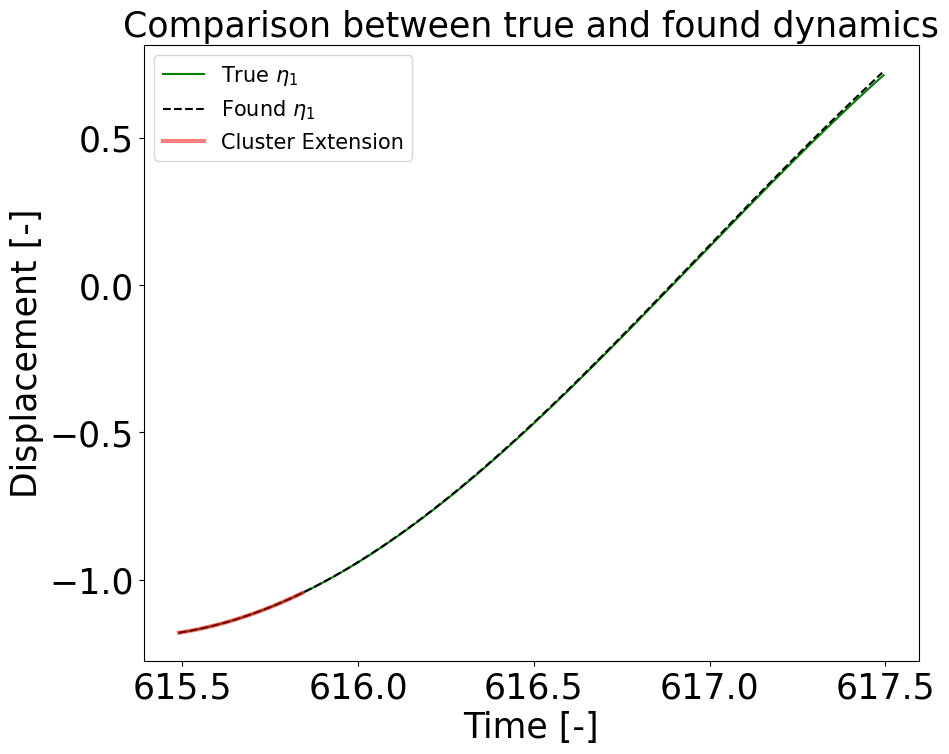

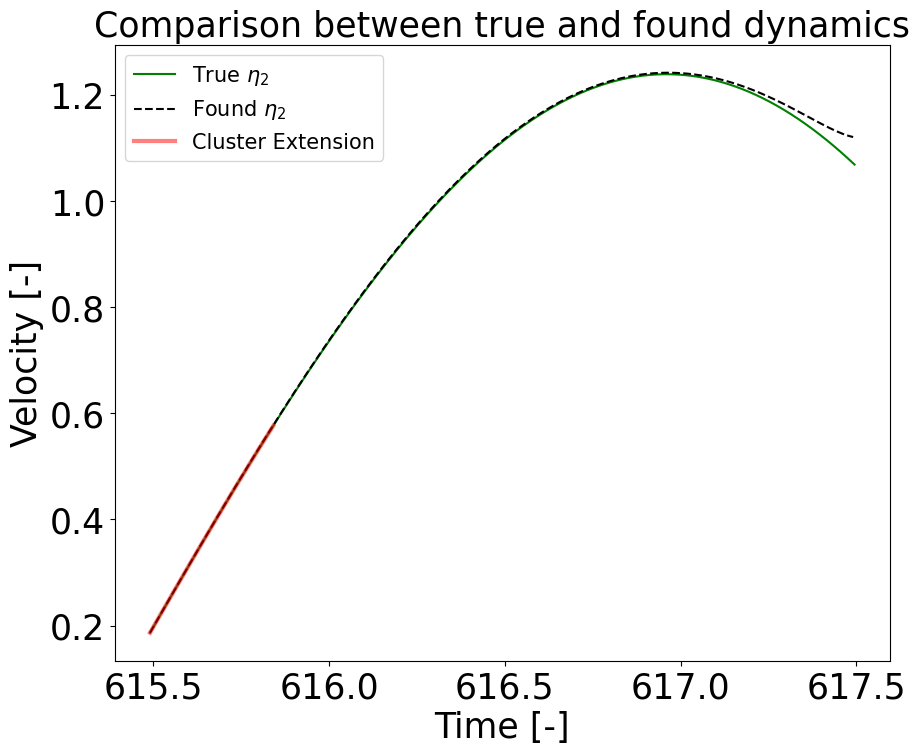

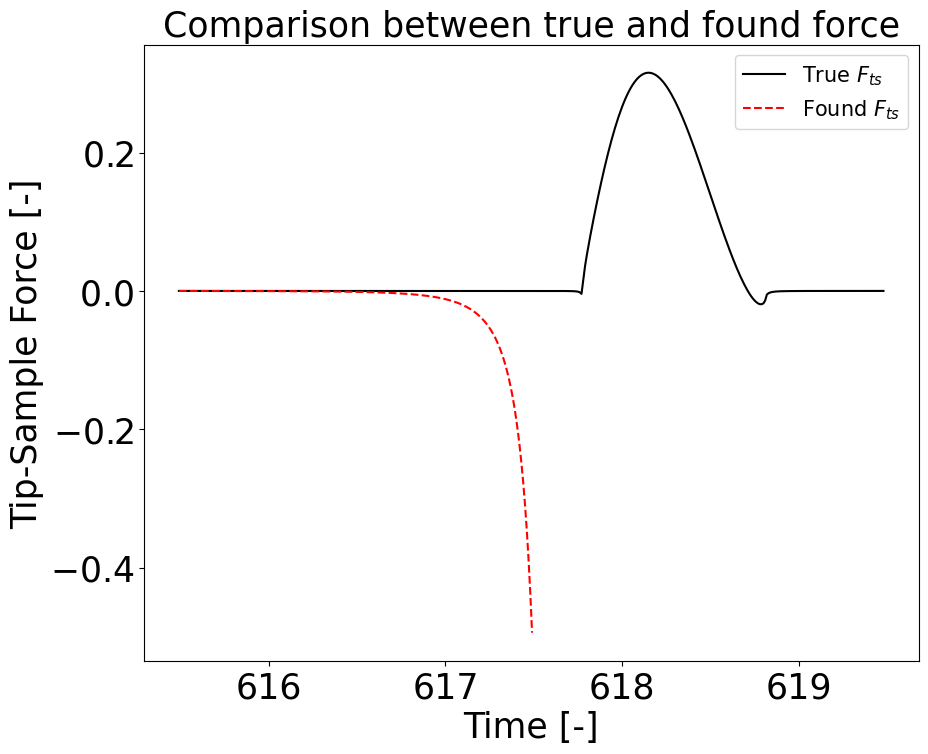

In [17]:
model_to_study = best_rel_AIC_c_C0_df['Candidate Model'][0]
cluster_to_test = 0

simulated_data_C0, extended_val_trajec_C0, F_ts_true_C0, F_ts_sim_C0 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, #'BDF'
                                                 plot = True)

## Analysis for Cluster No. 1

In [18]:
found_models_C1_df = mark_unique_models_in_dataframe(found_models_C1_df)

# Now filter unique models if needed:
unique_models_C1_df = found_models_C1_df[found_models_C1_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C1_df['Candidate Model'])) + ' unique models were found')
print('')
# for row in range(len(unique_models_C1_df)):
#     print(unique_models_C1_df.iloc[row][2], ': ', unique_models_C1_df.iloc[row][0].equations(precision = 9)[1])

A total of 100 unique models were found



### Checking repeated models

In [19]:
repeated_models_C1_df = found_models_C1_df[~found_models_C1_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C1_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within one cluster: Cluster 1

In [20]:
unique_models_to_analyze = unique_models_C1_df
analyzed_cluster = 1

simulated_information_C1, error_information_C1, AIC_models_in_cluster_C1 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C1 = get_relative_AIC_c_score(AIC_models_in_cluster_C1)

unique_models_C1_df['Delta_AIC_c'] = rel_AIC_c_lst_C1

Processing models: 100%|██████████| 100/100 [00:29<00:00,  3.40model/s]


## Best models within Cluster

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [21]:
# Filter rows where 'Delta AIC_c' is less than 1
pd.set_option('display.max_rows', None)
best_rel_AIC_c_C1_df = unique_models_C1_df[unique_models_C1_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C1_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0   04-02-25-041-1           1        11  1.6681005372000593e-05   
1   04-02-25-045-1           1        11  1.6681005372000593e-05   
2   04-02-25-061-1           1        11  2.1544346900318822e-06   
3   04-02-25-038-1           1        11  0.00035938136638046257   
4   05-02-25-073-1           1        11   7.742636826811278e-07   
5   04-02-25-004-1           1        11                   0.001   
6   04-02-25-015-1           1        11  0.00012915496650148828   
7   04-02-25-017-1           1        11  0.00012915496650148828   
8   05-02-25-094-1           1        11                   1e-07   
9   04-02-25-012-1           1        11  0.00012915496650148828   
10  04-02-25-022-1           1        11   2.782559402207126e-07   
11  04-02-25-039-1           1        11  0.00035938136638046257   
12  04-02-25-046-1           1        11  1.6681005372000593e-05   
13  04-02-25-030-1           1        11  0.00035938136638046257   
14  04-02-25-048-1           1        11  1.6681005372000593e-05   
15  04-02-25-024-1           1        11   2.782559402207126e-07   
16  05-02-25-082-1           1        11   4.641588833612772e-05   

                      Nu  Delta_AIC_c  
0   0.016681005372000592     0.990977  
1     0.0774263682681127     0.574440  
2   0.016681005372000592     0.846400  
3   0.021544346900318832     0.947355  
4   0.046415888336127774     0.033148  
5                    0.1     0.830247  
6     0.0774263682681127     0.329943  
7   0.027825594022071243     0.324050  
8                    0.1     0.398423  
9    0.01291549665014884     0.000000  
10   0.01291549665014884     0.129701  
11   0.03593813663804628     0.034753  
12   0.05994842503189409     0.444320  
13                  0.01     0.868174  
14  0.021544346900318832     0.405391  
15                   0.1     0.923899  
16   0.01291549665014884     0.834658

## Simulation of one of these candidate models for cluster 1

rms was: 0.07142262075012235
switch_ind was: 58

Equation with length: 11
(e1)' = 1.000000000 e2
(e2)' = -0.042582093 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -2.890993667 (0.0132626-1+e1)^1.5 + -2.200983726 (0.0132626-1+e1)^2 + -1.637913385 (0.0132626-1+e1)^2.5 + -4.156993156 ((0.0132626-1+e1)^0.5)*e2^1 + 1.110397714 ((0.0132626-1+e1)^0.5)*e2^2 + -1.666843517 ((0.0132626-1+e1)^1)*e2^1 + 0.573831855 ((0.0132626-1+e1)^1)*e2^2
(phase)' = 1.000000000 1



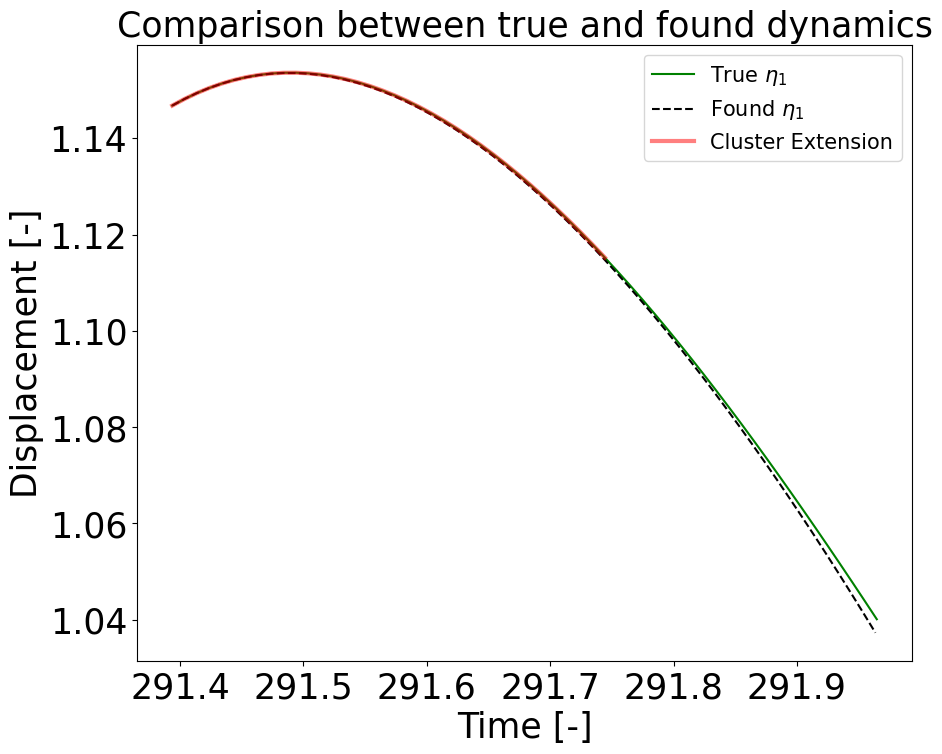

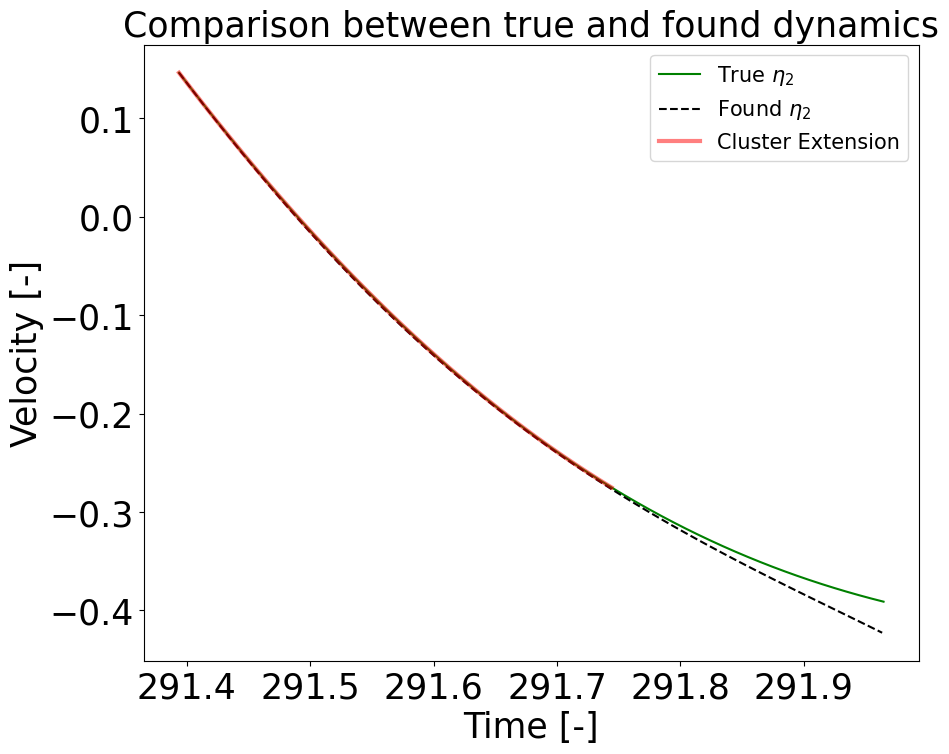

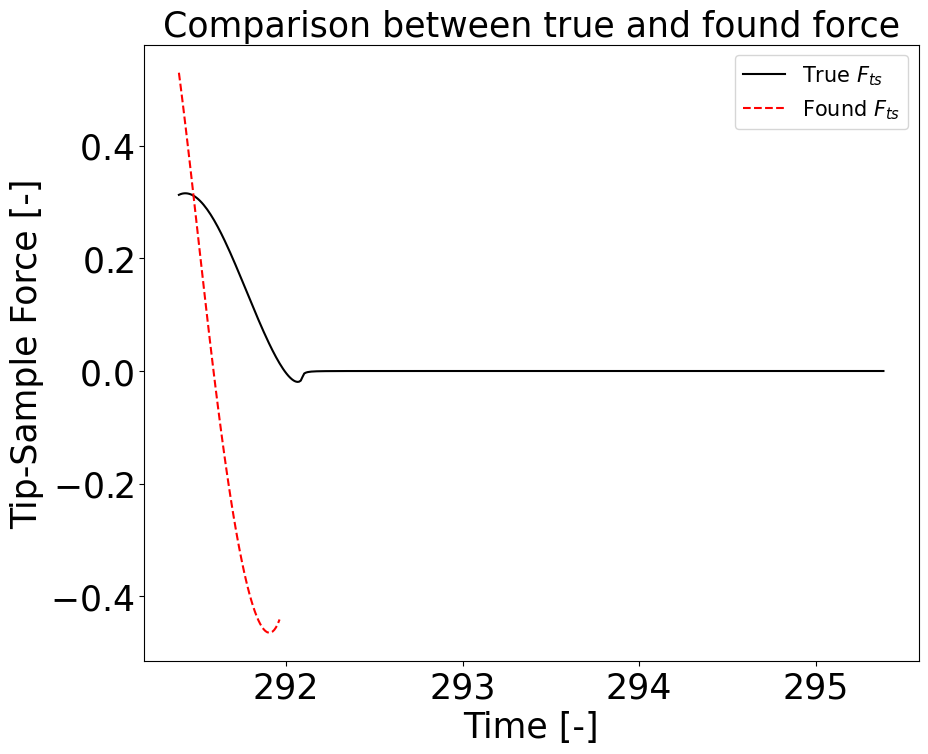

In [22]:
model_to_study = best_rel_AIC_c_C1_df['Candidate Model'][0] 
cluster_to_test = 1

simulated_data_C1, extended_val_trajec_C1, F_ts_true_C1, F_ts_sim_C1 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, force_plot_file_name = 'force_green', disp_plot_file_name = 'disp_green', vel_plot_file_name = 'vel_green',
                                                 plot = True, save=False)

## Analysis for Cluster No. 2

In [23]:
found_models_C2_df = mark_unique_models_in_dataframe(found_models_C2_df)

# Now filter unique models:
unique_models_C2_df = found_models_C2_df[found_models_C2_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C2_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 43 unique models were found



## AIC analysis for all models within one cluster: Cluster 2

In [24]:
unique_models_to_analyze = unique_models_C2_df
analyzed_cluster = 2

simulated_information_C2, error_information_C2, AIC_models_in_cluster_C2 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-5, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C2 = get_relative_AIC_c_score(AIC_models_in_cluster_C2)

unique_models_C2_df['Delta_AIC_c'] = rel_AIC_c_lst_C2

Processing models: 100%|██████████| 43/43 [00:09<00:00,  4.52model/s]


## Best models within Cluster

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model.

In [25]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C2_df = unique_models_C2_df[unique_models_C2_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C2_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  05-02-25-020-2           2         5   2.782559402207126e-07   
1  05-02-25-073-2           2         6   7.742636826811278e-07   
2  05-02-25-097-2           2         6                   1e-07   
3  05-02-25-022-2           2         5   2.782559402207126e-07   
4  05-02-25-072-2           2         5   7.742636826811278e-07   
5  05-02-25-027-2           2         6   2.782559402207126e-07   
6  05-02-25-076-2           2         6   7.742636826811278e-07   
7  05-02-25-026-2           2         6   2.782559402207126e-07   
8  05-02-25-094-2           2         6                   1e-07   
9  05-02-25-067-2           2         5  2.1544346900318822e-06   

                     Nu  Delta_AIC_c  
0                  0.01     0.008829  
1  0.046415888336127774     0.732829  
2  0.027825594022071243     0.969312  
3   0.01291549665014884     0.073129  
4   0.01291549665014884     0.000000  
5  0.027825594022071243     0.945668  
6   0.05994842503189409     0.761295  
7   0.05994842503189409     0.905300  
8                   0.1     0.877129  
9  0.027825594022071243     0.673906

## Simulation of one of these candidate models for cluster 2

rms was: 0.0002900846419802054
switch_ind was: 400

Equation with length: 5
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000005430 (1-e1)^-2 + -0.000000838 (1-e1)^-3
(phase)' = 1.000000000 1



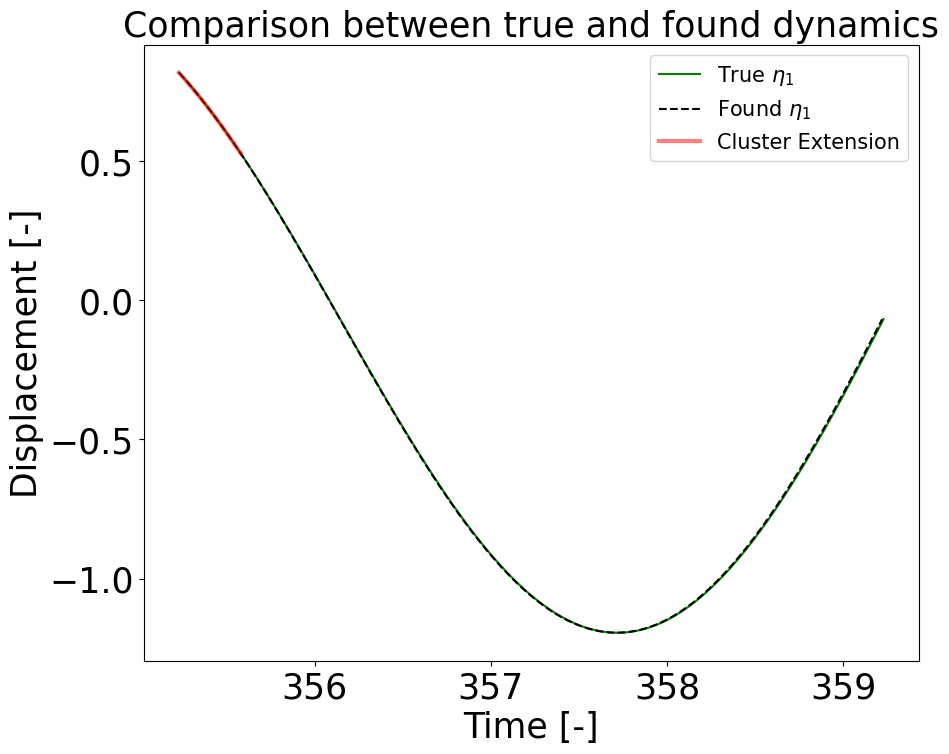

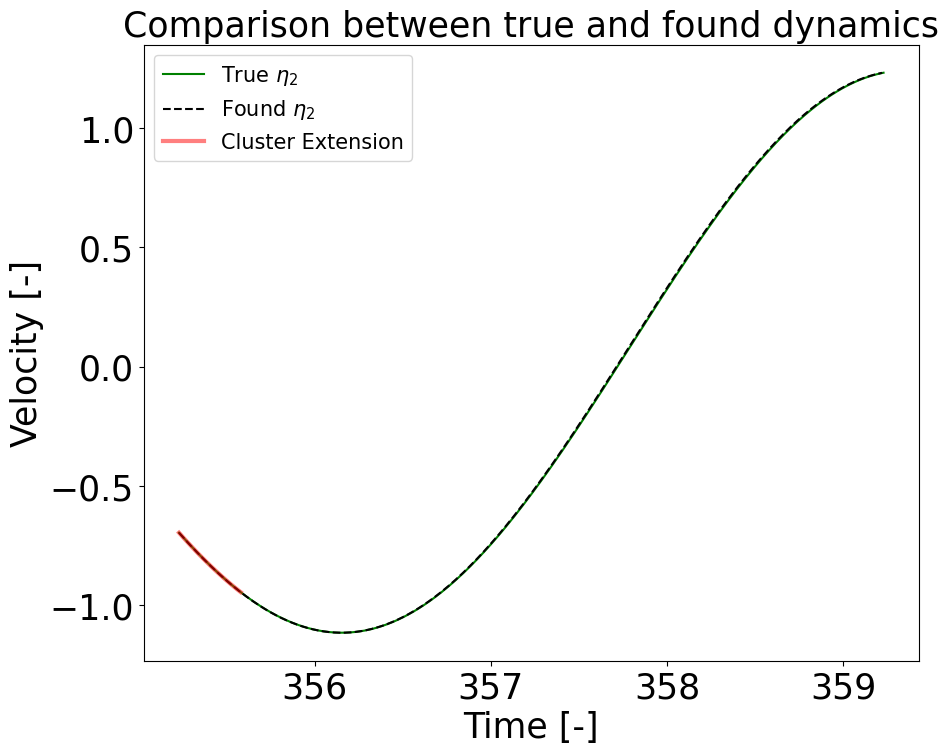

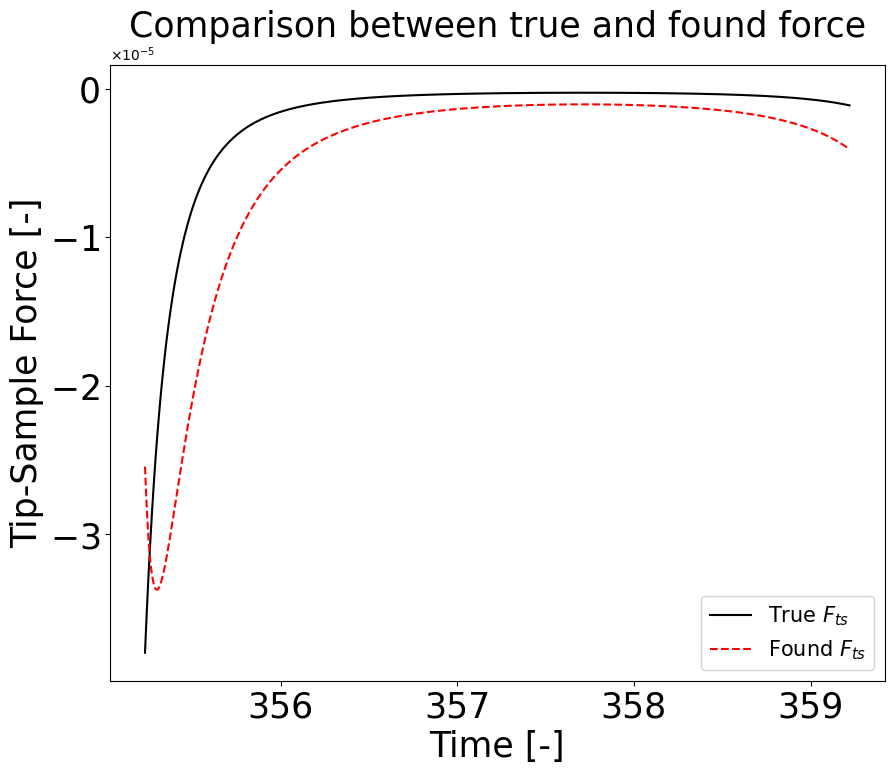

In [26]:
model_to_study = best_rel_AIC_c_C2_df['Candidate Model'][0]
cluster_to_test = 2

simulated_data_C2, extended_val_trajec_C2, F_ts_true_C2, F_ts_sim_C2 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 3

In [27]:
found_models_C3_df = mark_unique_models_in_dataframe(found_models_C3_df)

# Now filter unique models:
unique_models_C3_df = found_models_C3_df[found_models_C3_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C3_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 91 unique models were found



## AIC analysis for all models within one cluster: Cluster 3

In [28]:
unique_models_to_analyze = unique_models_C3_df
analyzed_cluster = 3

simulated_information_C3, error_information_C3, AIC_models_in_cluster_C3 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C3 = get_relative_AIC_c_score(AIC_models_in_cluster_C3)

unique_models_C3_df['Delta_AIC_c'] = rel_AIC_c_lst_C3

Processing models: 100%|██████████| 91/91 [00:23<00:00,  3.79model/s]


## Best models within Cluster 3

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model.

In [29]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C3_df = unique_models_C3_df[unique_models_C3_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C3_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda                   Nu  \
0  05-02-25-002-3           3         3  0.001  0.01291549665014884   

   Delta_AIC_c  
0          0.0

## Simulation of one of these candidate models for cluster 3

rms was: 0.00020939684686956993
switch_ind was: 400

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



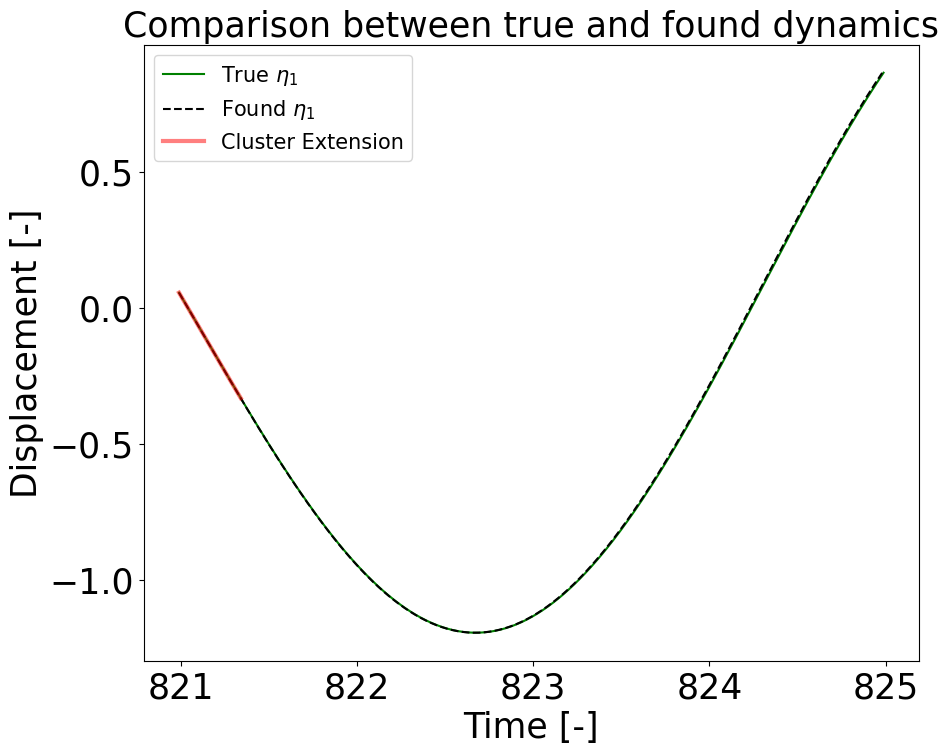

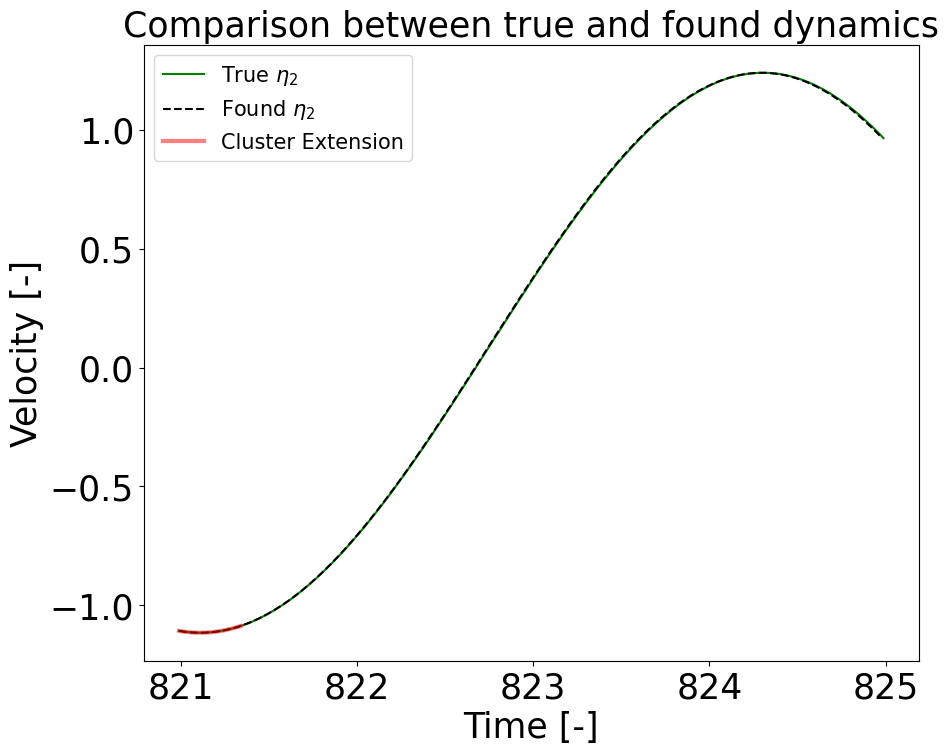

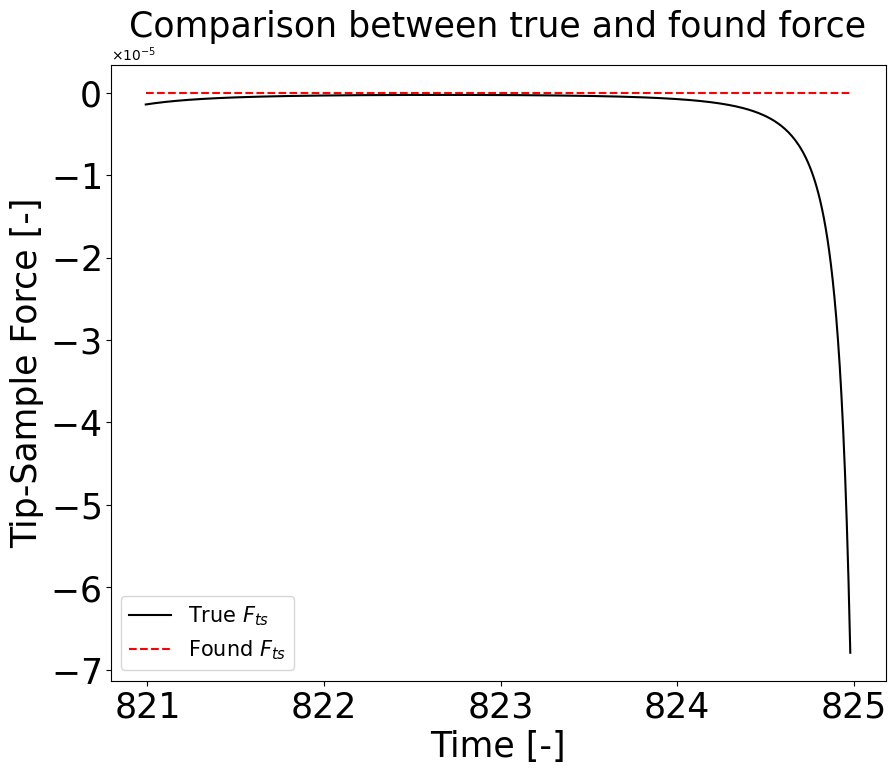

In [30]:
model_to_study = best_rel_AIC_c_C3_df['Candidate Model'][0]
cluster_to_test = 3

simulated_data_C3, extended_val_trajec_C3, F_ts_true_C3, F_ts_sim_C3 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 4

In [31]:
found_models_C4_df = mark_unique_models_in_dataframe(found_models_C4_df)

# Now filter unique models:
unique_models_C4_df = found_models_C4_df[found_models_C4_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C4_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 98 unique models were found



### Checking repeated models

In [32]:
repeated_models_C4_df = found_models_C4_df[~found_models_C4_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C4_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 2 repeated models were found



## AIC analysis for all models within one cluster: Cluster 4

In [33]:
unique_models_to_analyze = unique_models_C4_df
analyzed_cluster = 4

simulated_information_C4, error_information_C4, AIC_models_in_cluster_C4 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C4 = get_relative_AIC_c_score(AIC_models_in_cluster_C4)

unique_models_C4_df['Delta_AIC_c'] = rel_AIC_c_lst_C4

Processing models: 100%|██████████| 98/98 [00:31<00:00,  3.09model/s]


## Best models within Cluster

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [34]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C4_df = unique_models_C4_df[unique_models_C4_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C4_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                 Lambda  \
0  05-02-25-004-4           4         3                  0.001   
1  05-02-25-083-4           4         5  4.641588833612772e-05   

                     Nu  Delta_AIC_c  
0                   0.1     0.819784  
1  0.046415888336127774     0.000000

## Simulation of one of these candidate models for cluster 4

rms was: 0.1275938354925772
switch_ind was: 340

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



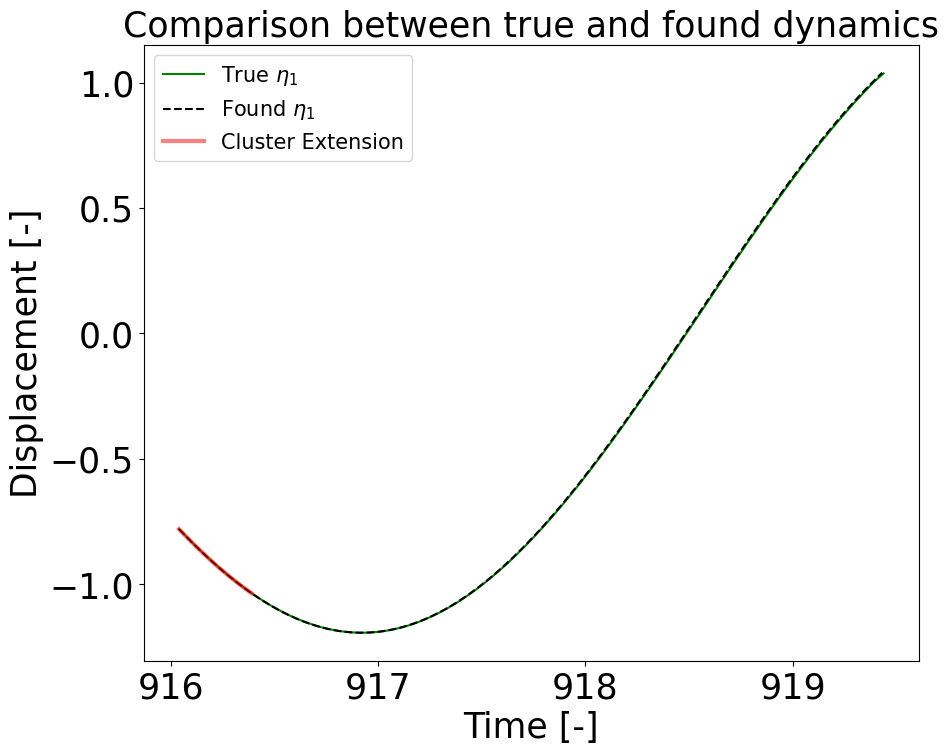

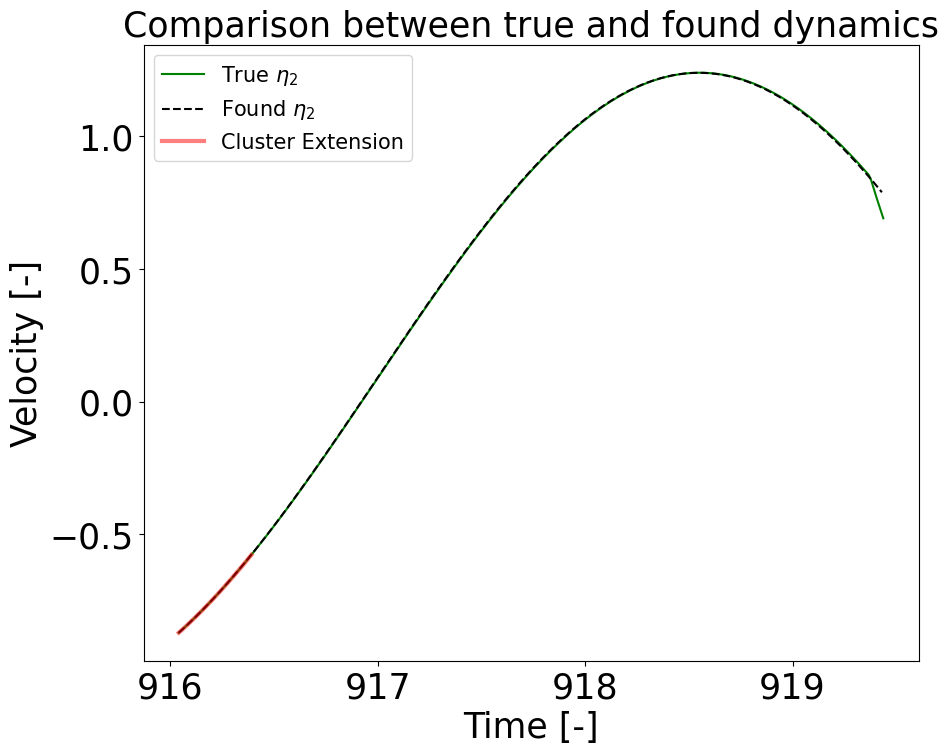

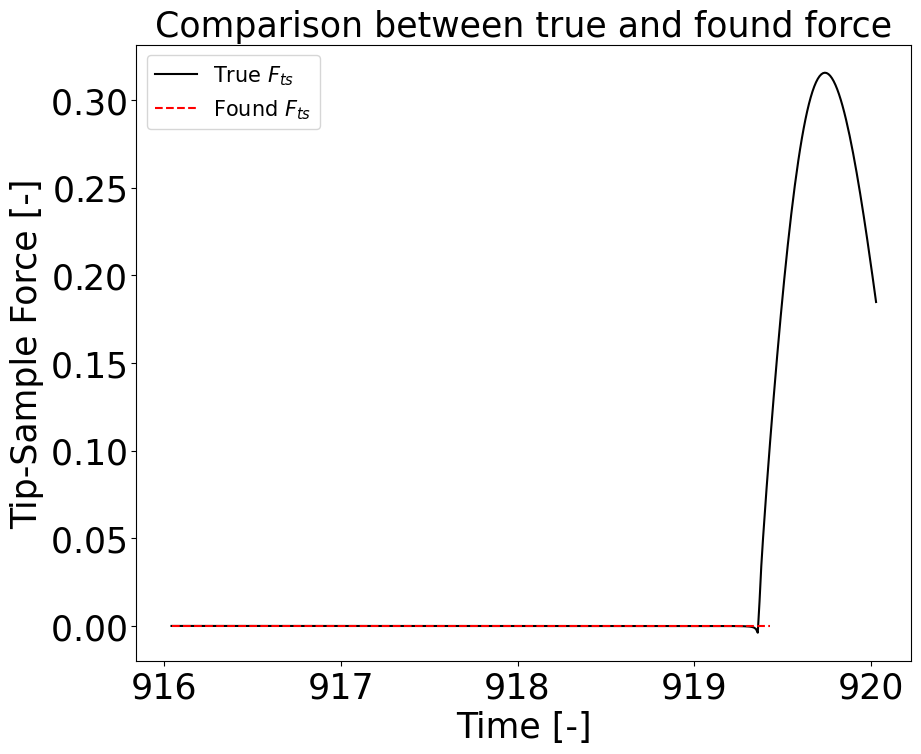

In [35]:
model_to_study = best_rel_AIC_c_C4_df['Candidate Model'][0]
cluster_to_test = 4

simulated_data_C4, extended_val_trajec_C4, F_ts_true_C4, F_ts_sim_C4 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, force_plot_file_name = 'force_rep', disp_plot_file_name = 'disp_rep', vel_plot_file_name = 'vel_rep',
                                                 plot = True, F_xlim = None, save = False)

## Analysis for Cluster No. 5

In [36]:
found_models_C5_df = mark_unique_models_in_dataframe(found_models_C5_df)

# Now filter unique models:
unique_models_C5_df = found_models_C5_df[found_models_C5_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C5_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



### Checking repeated models

In [37]:
repeated_models_C5_df = found_models_C5_df[~found_models_C5_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C5_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within Cluster 5

In [38]:
unique_models_to_analyze = unique_models_C5_df
analyzed_cluster = 5

simulated_information_C5, error_information_C5, AIC_models_in_cluster_C5 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C5 = get_relative_AIC_c_score(AIC_models_in_cluster_C5)

unique_models_C5_df['Delta_AIC_c'] = rel_AIC_c_lst_C5

Processing models: 100%|██████████| 100/100 [00:35<00:00,  2.83model/s]


## Best models within Cluster

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [39]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C5_df = unique_models_C5_df[unique_models_C5_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C5_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                 Lambda  \
0  05-02-25-021-5           5         6  2.782559402207126e-07   
1  05-02-25-081-5           5         6  4.641588833612772e-05   
2  05-02-25-073-5           5         6  7.742636826811278e-07   

                     Nu  Delta_AIC_c  
0  0.016681005372000592     0.000000  
1  0.016681005372000592     0.729179  
2  0.046415888336127774     0.169980

## Simulation of one of these candidate models for cluster 5

rms was: 5.289285060519973
switch_ind was: 116

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.000208227 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.014105361 (1-e1)^-2 + 0.028639089 (1-e1)^-3
(phase)' = 1.000000000 1



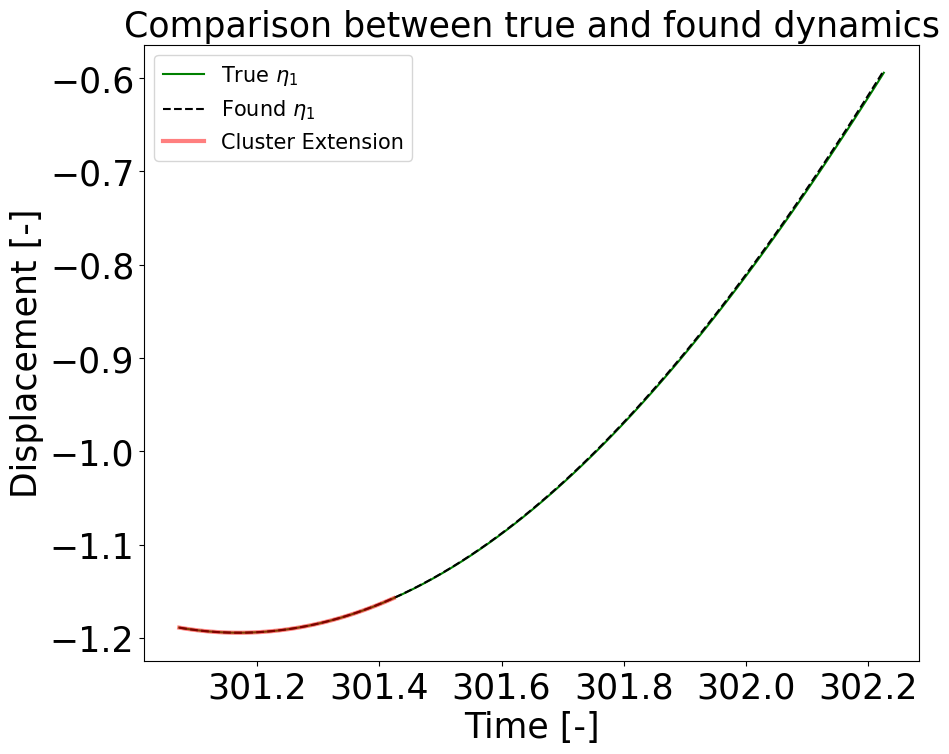

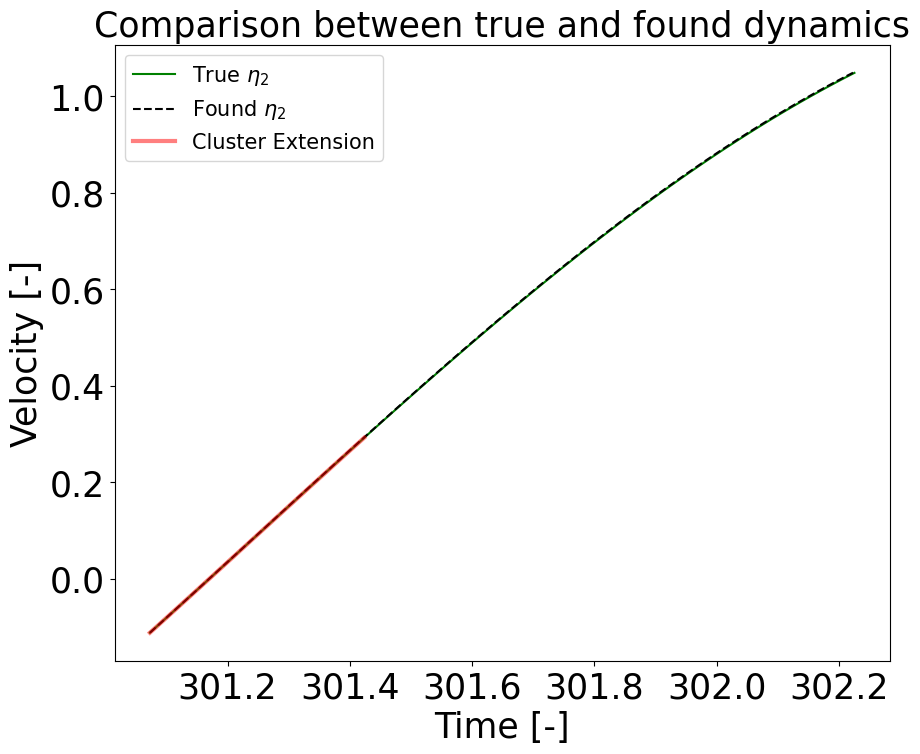

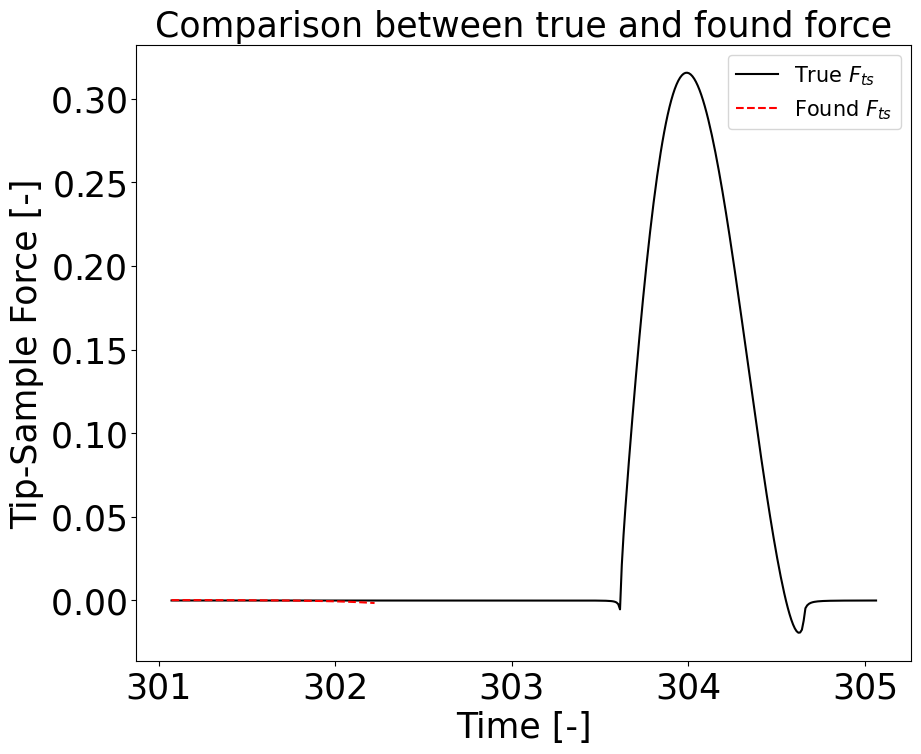

In [40]:
model_to_study = best_rel_AIC_c_C5_df['Candidate Model'][0]
cluster_to_test = 5

simulated_data_C5, extended_val_trajec_C5, F_ts_true_C5, F_ts_sim_C5 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-4,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, force_plot_file_name = 'force_orange', disp_plot_file_name = 'disp_orange', vel_plot_file_name = 'vel_orange',
                                                 plot = True, F_xlim = None, save=False)

## Analysis for Cluster No. 6

In [41]:
found_models_C6_df = mark_unique_models_in_dataframe(found_models_C6_df)

# Now filter unique models:
unique_models_C6_df = found_models_C6_df[found_models_C6_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C6_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 6

In [42]:
unique_models_to_analyze = unique_models_C6_df
analyzed_cluster = 6

simulated_information_C6, error_information_C6, AIC_models_in_cluster_C6 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C6 = get_relative_AIC_c_score(AIC_models_in_cluster_C6)

unique_models_C6_df['Delta_AIC_c'] = rel_AIC_c_lst_C6

Processing models: 100%|██████████| 100/100 [00:29<00:00,  3.39model/s]


## Best models within Cluster 6

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [43]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C6_df = unique_models_C6_df[unique_models_C6_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C6_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0   06-02-25-036-6           6        11  0.00035938136638046257   
1   05-02-25-009-6           6        10                   0.001   
2   05-02-25-001-6           6        11                   0.001   
3   06-02-25-030-6           6        11  0.00035938136638046257   
4   05-02-25-002-6           6        10                   0.001   
5   06-02-25-058-6           6        11   5.994842503189409e-06   
6   06-02-25-078-6           6        11   7.742636826811278e-07   
7   06-02-25-059-6           6        11   5.994842503189409e-06   
8   06-02-25-051-6           6        11   5.994842503189409e-06   
9   06-02-25-065-6           6        11  2.1544346900318822e-06   
10  06-02-25-080-6           6        11   4.641588833612772e-05   
11  06-02-25-027-6           6        11   2.782559402207126e-07   
12  06-02-25-043-6           6        11  1.6681005372000593e-05   
13  06-02-25-098-6           6        11                   1e-07   
14  06-02-25-089-6           6        11   4.641588833612772e-05   
15  06-02-25-039-6           6        10  0.00035938136638046257   
16  05-02-25-006-6           6        11                   0.001   
17  06-02-25-025-6           6        11   2.782559402207126e-07   
18  06-02-25-067-6           6        11  2.1544346900318822e-06   
19  06-02-25-010-6           6        11  0.00012915496650148828   
20  06-02-25-092-6           6        11                   1e-07   
21  06-02-25-068-6           6        11  2.1544346900318822e-06   

                      Nu  Delta_AIC_c  
0    0.05994842503189409     0.927429  
1    0.03593813663804628     0.000000  
2   0.016681005372000592     0.327132  
3                   0.01     0.642557  
4    0.01291549665014884     0.517518  
5   0.021544346900318832     0.325422  
6   0.021544346900318832     0.920180  
7    0.03593813663804628     0.857050  
8   0.016681005372000592     0.908410  
9     0.0774263682681127     0.678484  
10                  0.01     0.432416  
11  0.027825594022071243     0.512587  
12  0.046415888336127774     0.642272  
13  0.021544346900318832     0.815735  
14   0.03593813663804628     0.789815  
15   0.03593813663804628     0.126547  
16   0.05994842503189409     0.390170  
17    0.0774263682681127     0.603712  
18  0.027825594022071243     0.582778  
19                  0.01     0.962833  
20   0.01291549665014884     0.422402  
21  0.021544346900318832     0.085858

## Simulation of one of these candidate models for cluster 6

rms was: 0.16169490387982757
switch_ind was: 62

Equation with length: 11
(e1)' = 1.000000000 e2
(e2)' = -0.184268063 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -1.038968636 (0.0132626-1+e1)^1.5 + -1.329832085 (0.0132626-1+e1)^2 + -0.871406224 (0.0132626-1+e1)^2.5 + -4.361276502 ((0.0132626-1+e1)^0.5)*e2^1 + -0.506353006 ((0.0132626-1+e1)^0.5)*e2^2 + 1.111780889 ((0.0132626-1+e1)^1)*e2^1 + -4.779658225 ((0.0132626-1+e1)^1)*e2^2
(phase)' = 1.000000000 1



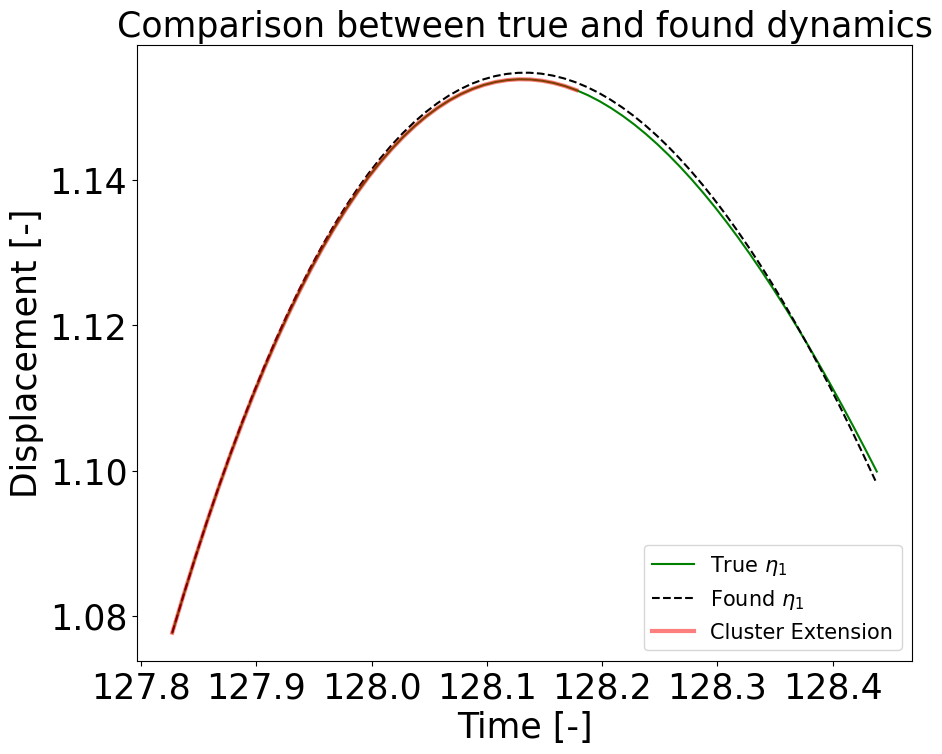

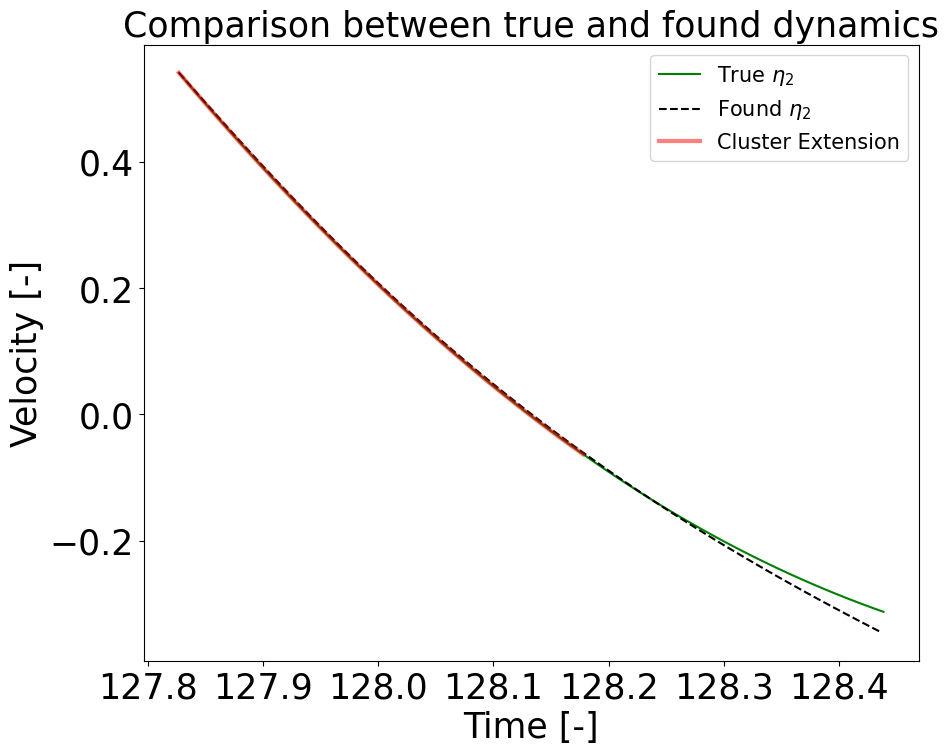

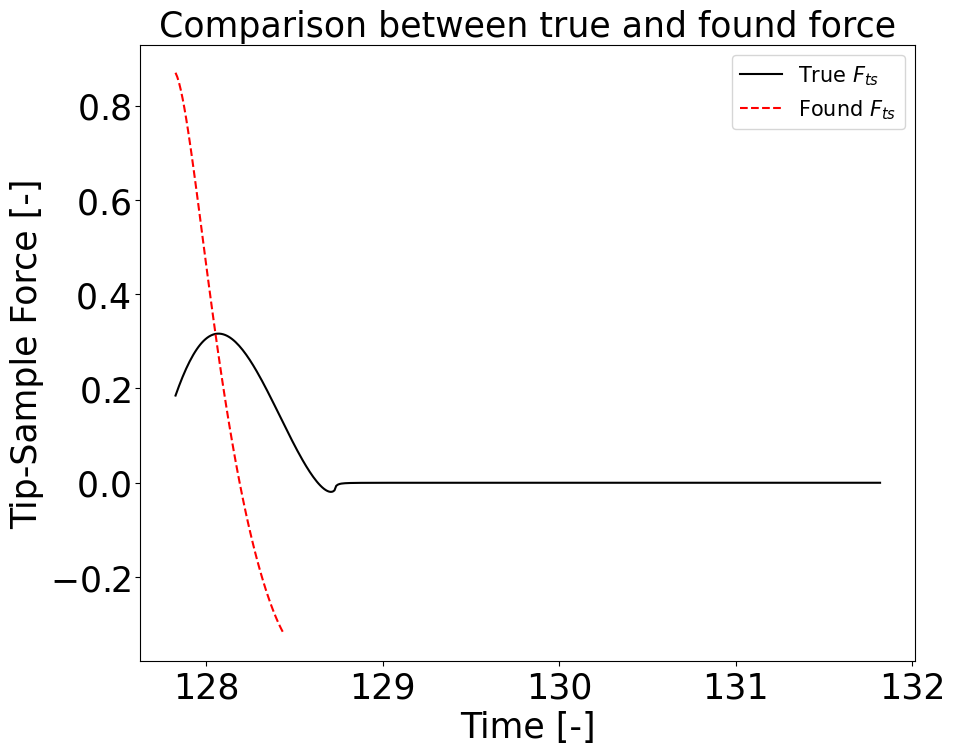

In [44]:
model_to_study = best_rel_AIC_c_C6_df['Candidate Model'][0]
cluster_to_test = 6

simulated_data_C6, extended_val_trajec_C6, F_ts_true_C6, F_ts_sim_C6 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, 
                                                 disp_plot_file_name= 'rep_aic_ts_disp_no_viscoelastic_terms', vel_plot_file_name = 'rep_aic_ts_vel_no_viscoelastic_terms', force_plot_file_name= 'rep_aic_ts_force_no_viscoelastic_terms',
                                                 plot = True, save=False)

## Analysis for Cluster No. 7

In [45]:
found_models_C7_df = mark_unique_models_in_dataframe(found_models_C7_df)

# Now filter unique models:
unique_models_C7_df = found_models_C7_df[found_models_C7_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C7_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 32 unique models were found



## AIC analysis for all models within one cluster: Cluster 7

In [46]:
unique_models_to_analyze = unique_models_C7_df
analyzed_cluster = 7

simulated_information_C7, error_information_C7, AIC_models_in_cluster_C7 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject], model_type = 'Viscoelastic DMT',
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4,
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C7 = get_relative_AIC_c_score(AIC_models_in_cluster_C7)

unique_models_C7_df['Delta_AIC_c'] = rel_AIC_c_lst_C7

Processing models: 100%|██████████| 32/32 [00:06<00:00,  4.90model/s]


## Best models within Cluster 7

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [ ]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C7_df = unique_models_C7_df[unique_models_C7_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C7_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                 Lambda  \
0   06-02-25-090-7           7         5                  1e-07   
1   06-02-25-073-7           7         5  7.742636826811278e-07   
2   06-02-25-025-7           7         5  2.782559402207126e-07   
3   06-02-25-020-7           7         5  2.782559402207126e-07   
4   06-02-25-078-7           7         5  7.742636826811278e-07   
5   06-02-25-029-7           7         5  2.782559402207126e-07   
6   06-02-25-079-7           7         5  7.742636826811278e-07   
7   06-02-25-024-7           7         5  2.782559402207126e-07   
8   06-02-25-027-7           7         5  2.782559402207126e-07   
9   06-02-25-026-7           7         5  2.782559402207126e-07   
10  06-02-25-076-7           7         5  7.742636826811278e-07   
11  06-02-25-096-7           7         5                  1e-07   
12  06-02-25-097-7           7         5                  1e-07   
13  06-02-25-021-7           7         5  2.782559402207126e-07   
14  06-02-25-072-7           7         5  7.742636826811278e-07   
15  06-02-25-022-7           7         5  2.782559402207126e-07   
16  06-02-25-070-7           7         5  7.742636826811278e-07   
17  06-02-25-091-7           7         5                  1e-07   
18  06-02-25-074-7           7         5  7.742636826811278e-07   
19  06-02-25-094-7           7         5                  1e-07   
20  06-02-25-023-7           7         5  2.782559402207126e-07   
21  06-02-25-077-7           7         5  7.742636826811278e-07   
22  06-02-25-075-7           7         5  7.742636826811278e-07   
23  06-02-25-028-7           7         5  2.782559402207126e-07   
24  06-02-25-098-7           7         5                  1e-07   

                      Nu  Delta_AIC_c  
0                   0.01     1.087888  
1   0.046415888336127774     0.722823  
2     0.0774263682681127     1.662960  
3                   0.01     0.000000  
4   0.021544346900318832     1.792628  
5    0.03593813663804628     1.505257  
6    0.03593813663804628     0.842243  
7                    0.1     0.553696  
8   0.027825594022071243     1.287581  
9    0.05994842503189409     1.750322  
10   0.05994842503189409     1.374969  
11   0.05994842503189409     1.853322  
12  0.027825594022071243     0.398569  
13  0.016681005372000592     1.666553  
14   0.01291549665014884     1.061492  
15   0.01291549665014884     0.958205  
16                  0.01     1.656981  
17  0.016681005372000592     1.213203  
18                   0.1     0.158454  
19                   0.1     1.239468  
20  0.046415888336127774     0.500131  
21  0.027825594022071243     0.399370  
22    0.0774263682681127     1.612677  
23  0.021544346900318832     0.947077  
24  0.021544346900318832     0.235887

## Simulation of one of these candidate models for cluster 7

rms was: 0.0002957050130614314
switch_ind was: 400

Equation with length: 5
(e1)' = 1.000000000 e2
(e2)' = 0.000009789 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000001347 (1-e1)^-2
(phase)' = 1.000000000 1



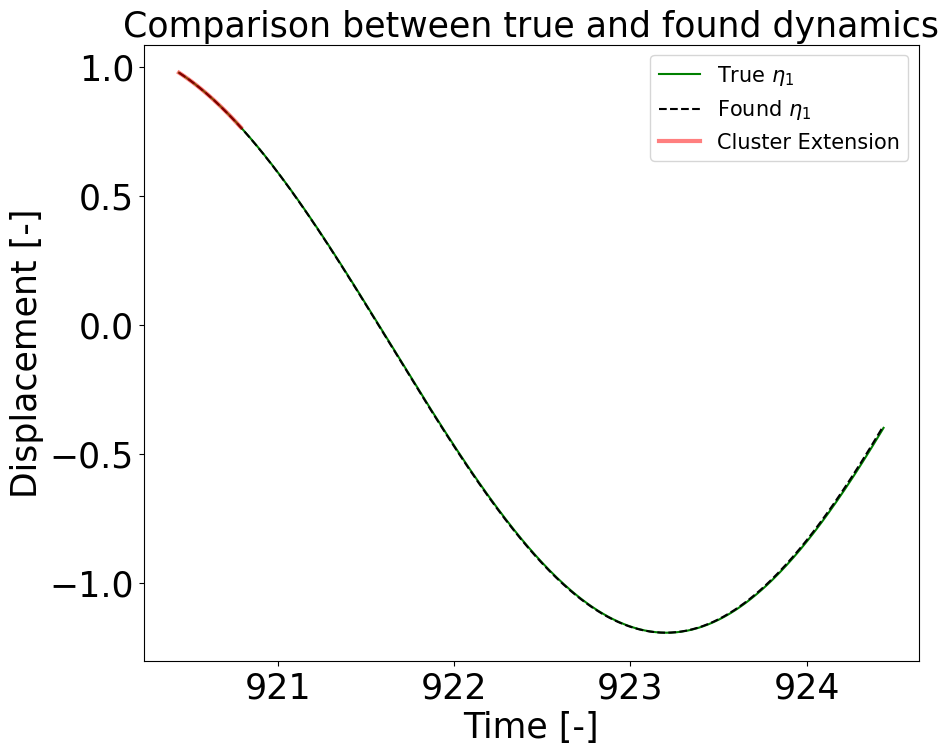

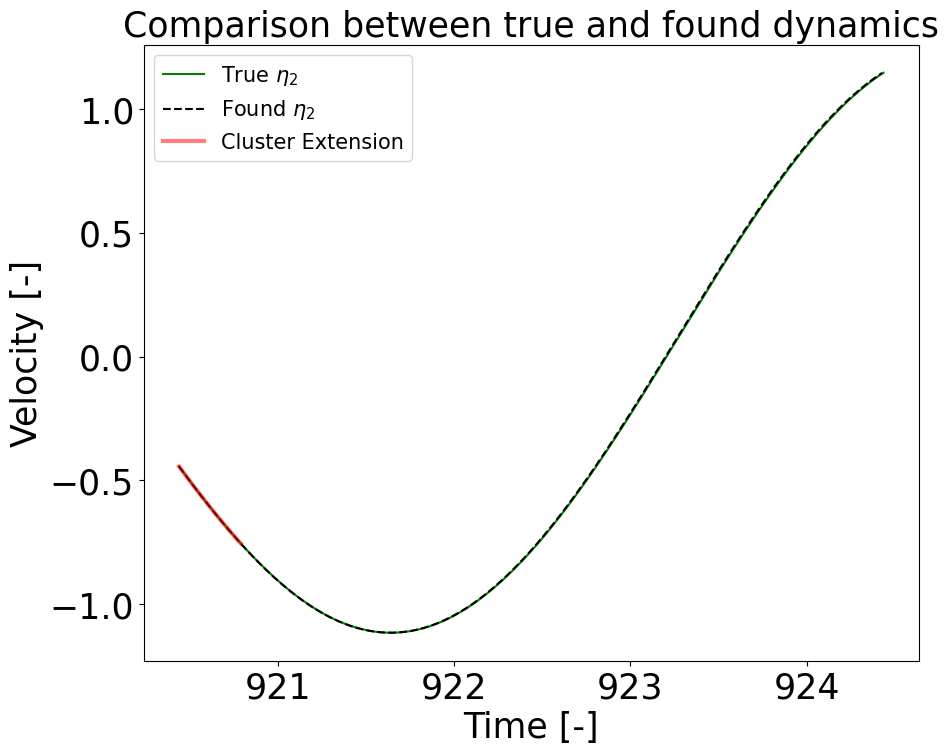

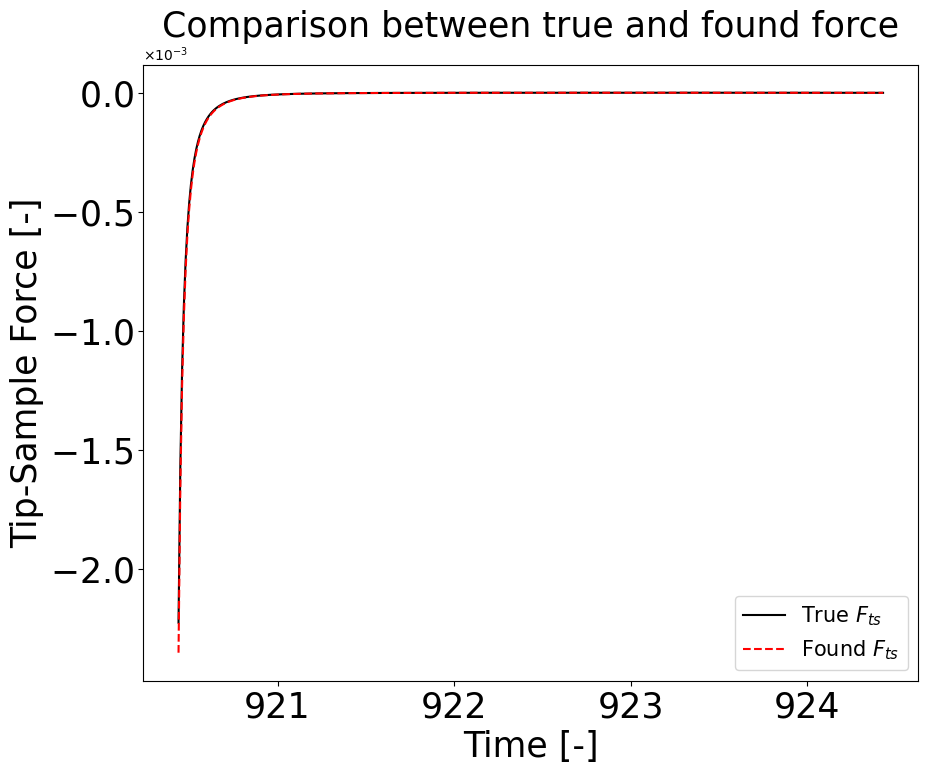

In [48]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][3] 
cluster_to_test = 7                                          

simulated_data_C7, extended_val_trajec_C7, F_ts_true_C7, F_ts_sim_C7 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 8

In [49]:
found_models_C8_df = mark_unique_models_in_dataframe(found_models_C8_df)

# Now filter unique models:
unique_models_C8_df = found_models_C8_df[found_models_C8_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C8_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 69 unique models were found



## AIC analysis for all models within one cluster: Cluster 8

In [50]:
unique_models_to_analyze = unique_models_C8_df
analyzed_cluster = 8

simulated_information_C8, error_information_C8, AIC_models_in_cluster_C8 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C8 = get_relative_AIC_c_score(AIC_models_in_cluster_C8)

unique_models_C8_df['Delta_AIC_c'] = rel_AIC_c_lst_C8

Processing models: 100%|██████████| 69/69 [00:16<00:00,  4.30model/s]


## Best models within Cluster 8

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [51]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C8_df = unique_models_C8_df[unique_models_C8_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C8_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  06-02-25-010-8           8         3  0.00012915496650148828   
1  06-02-25-076-8           8         5   7.742636826811278e-07   

                    Nu  Delta_AIC_c  
0                 0.01     0.255131  
1  0.05994842503189409     0.000000

## Simulation of one of these candidate models for cluster 8

rms was: 0.00022408597549260093
switch_ind was: 400

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



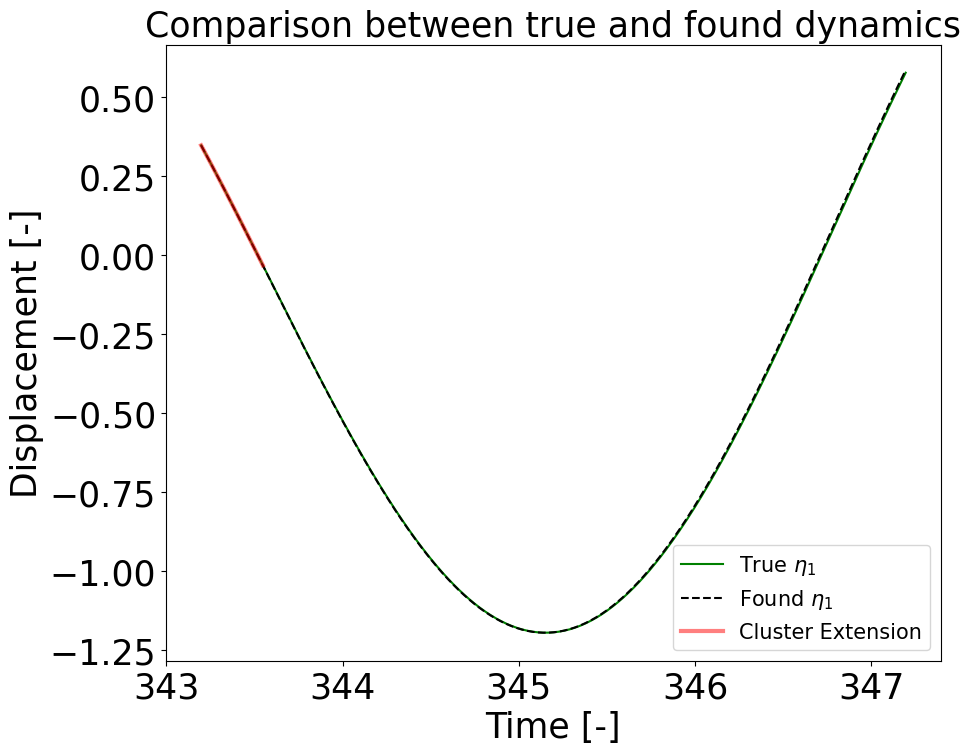

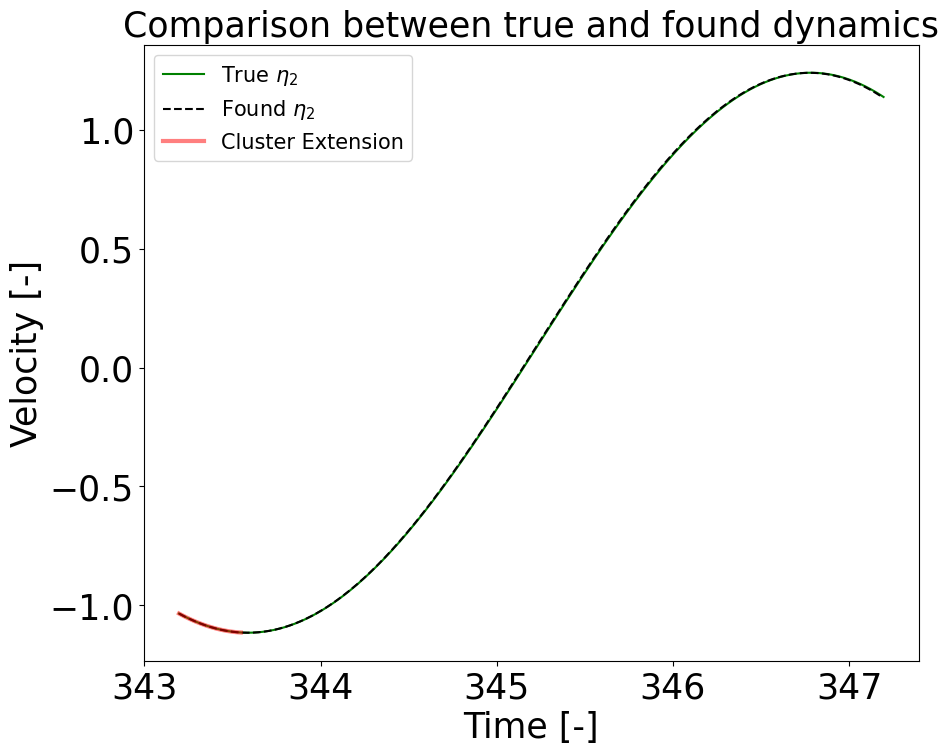

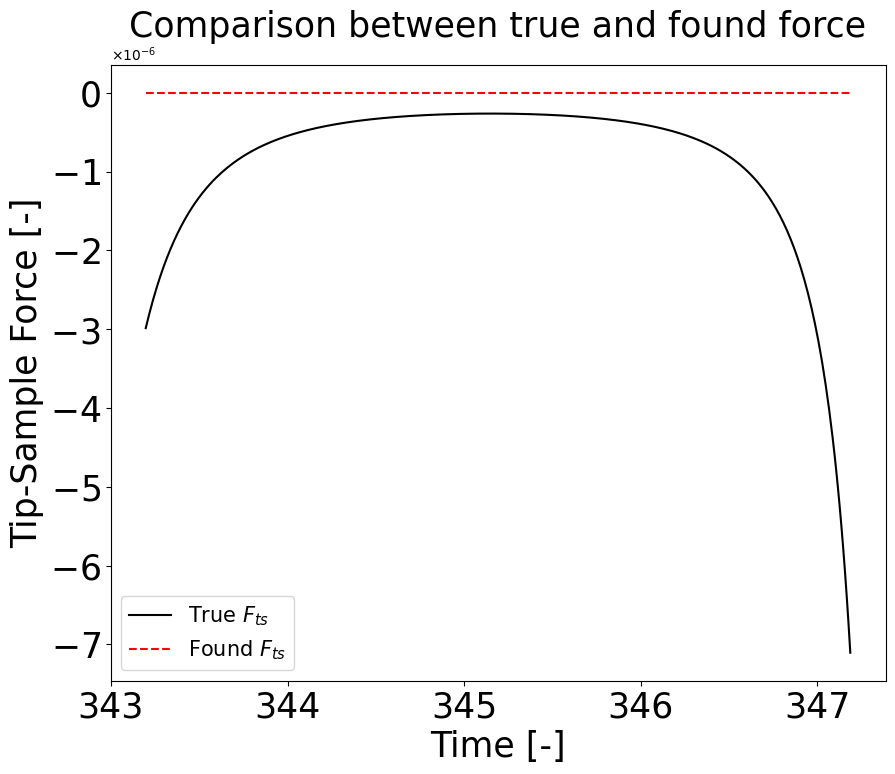

In [52]:
model_to_study = best_rel_AIC_c_C8_df['Candidate Model'][0]
cluster_to_test = 8

simulated_data_C8, extended_val_trajec_C8, F_ts_true_C8, F_ts_sim_C8 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 9

In [53]:
found_models_C9_df = mark_unique_models_in_dataframe(found_models_C9_df)

# Now filter unique models:
unique_models_C9_df = found_models_C9_df[found_models_C9_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C9_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 9

In [54]:
unique_models_to_analyze = unique_models_C9_df
analyzed_cluster = 9

simulated_information_C9, error_information_C9, AIC_models_in_cluster_C9 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C9 = get_relative_AIC_c_score(AIC_models_in_cluster_C9)

unique_models_C9_df['Delta_AIC_c'] = rel_AIC_c_lst_C9

Processing models: 100%|██████████| 100/100 [00:34<00:00,  2.91model/s]


## Best models within Cluster 9

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [55]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C9_df = unique_models_C9_df[unique_models_C9_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C9_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  06-02-25-010-9           9         5  0.00012915496650148828   
1  06-02-25-046-9           9         6  1.6681005372000593e-05   

                    Nu  Delta_AIC_c  
0                 0.01     0.000000  
1  0.05994842503189409     0.703237

## Simulation of one of these candidate models for cluster 9

rms was: 0.08745802273777283
switch_ind was: 176

Equation with length: 5
(e1)' = 1.000000000 e2
(e2)' = -0.000104847 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000307483 (1-e1)^-2
(phase)' = 1.000000000 1



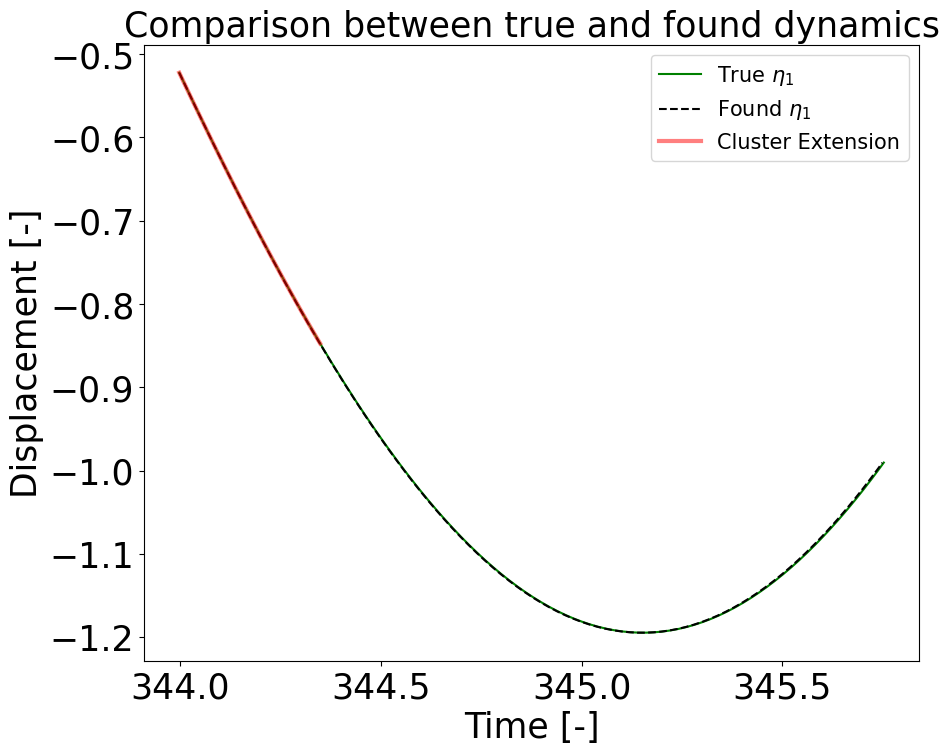

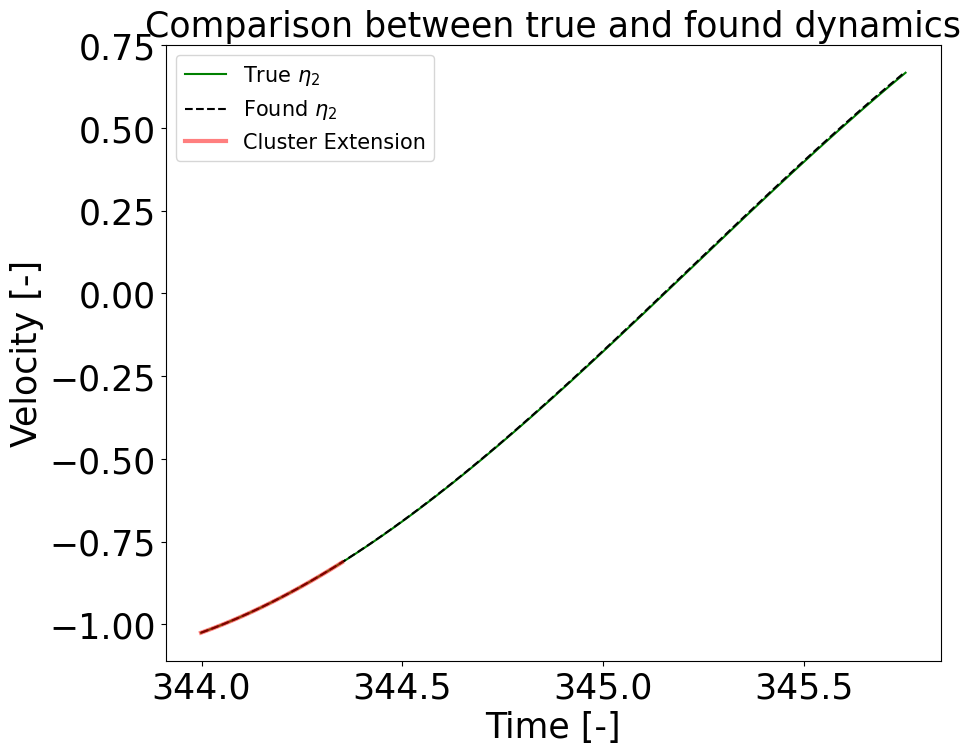

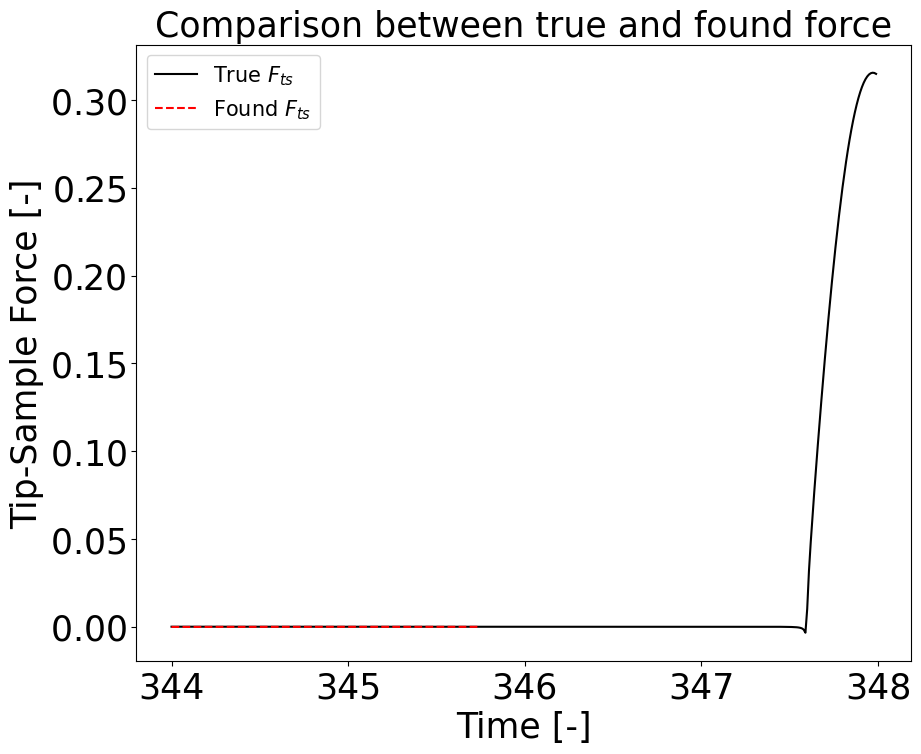

In [56]:
model_to_study = best_rel_AIC_c_C9_df['Candidate Model'][0]
cluster_to_test = 9

simulated_data_C9, extended_val_trajec_C9, F_ts_true_C9, F_ts_sim_C9 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-4,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, 
                                                 plot = True)

## Analysis for Cluster No. 10

In [57]:
found_models_C10_df = mark_unique_models_in_dataframe(found_models_C10_df)

# Now filter unique models:
unique_models_C10_df = found_models_C10_df[found_models_C10_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C10_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 10

In [58]:
unique_models_to_analyze = unique_models_C10_df
analyzed_cluster = 10

simulated_information_C10, error_information_C10, AIC_models_in_cluster_C10 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C10 = get_relative_AIC_c_score(AIC_models_in_cluster_C10)

unique_models_C10_df['Delta_AIC_c'] = rel_AIC_c_lst_C10

Processing models: 100%|██████████| 100/100 [00:38<00:00,  2.60model/s]


## Best models within Cluster 10

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [59]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C10_df = unique_models_C10_df[unique_models_C10_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C10_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  06-02-25-025-10          10         6   2.782559402207126e-07   
1  07-02-25-075-10          10         6   7.742636826811278e-07   
2  06-02-25-015-10          10         6  0.00012915496650148828   
3  07-02-25-083-10          10         6   4.641588833612772e-05   
4  06-02-25-026-10          10         6   2.782559402207126e-07   

                     Nu  Delta_AIC_c  
0    0.0774263682681127     0.000000  
1    0.0774263682681127     0.376099  
2    0.0774263682681127     0.651234  
3  0.046415888336127774     0.830276  
4   0.05994842503189409     0.128210

## Simulation of one of these candidate models for cluster 10

rms was: 6.983149834503974
switch_ind was: 231

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = -0.001236925 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.013674135 (1-e1)^-2 + 0.048613019 (1-e1)^-3
(phase)' = 1.000000000 1



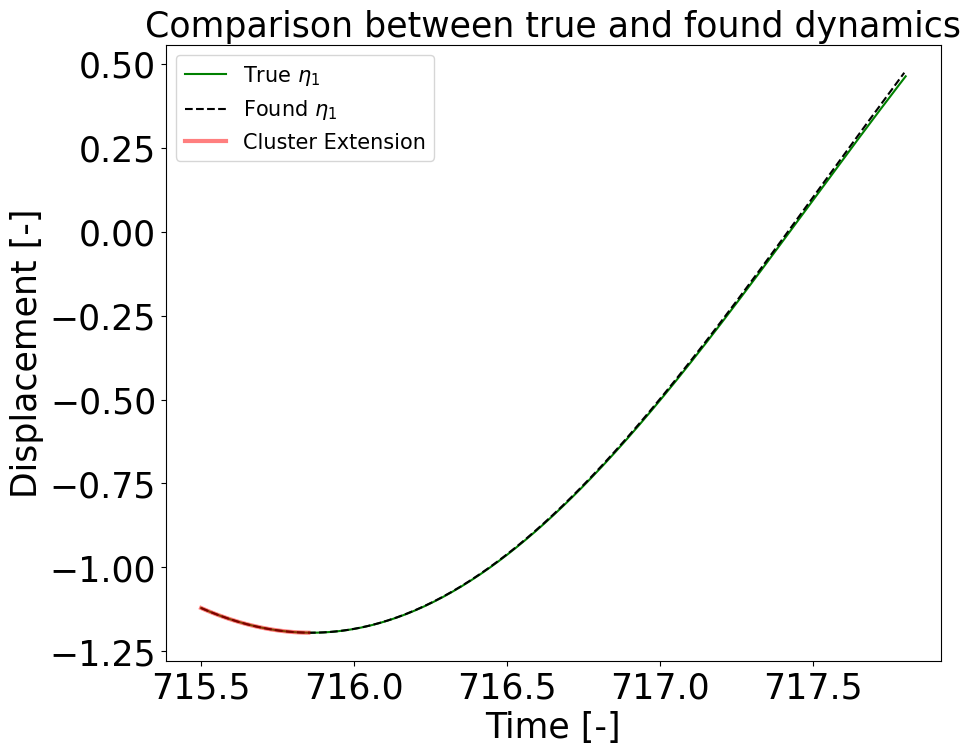

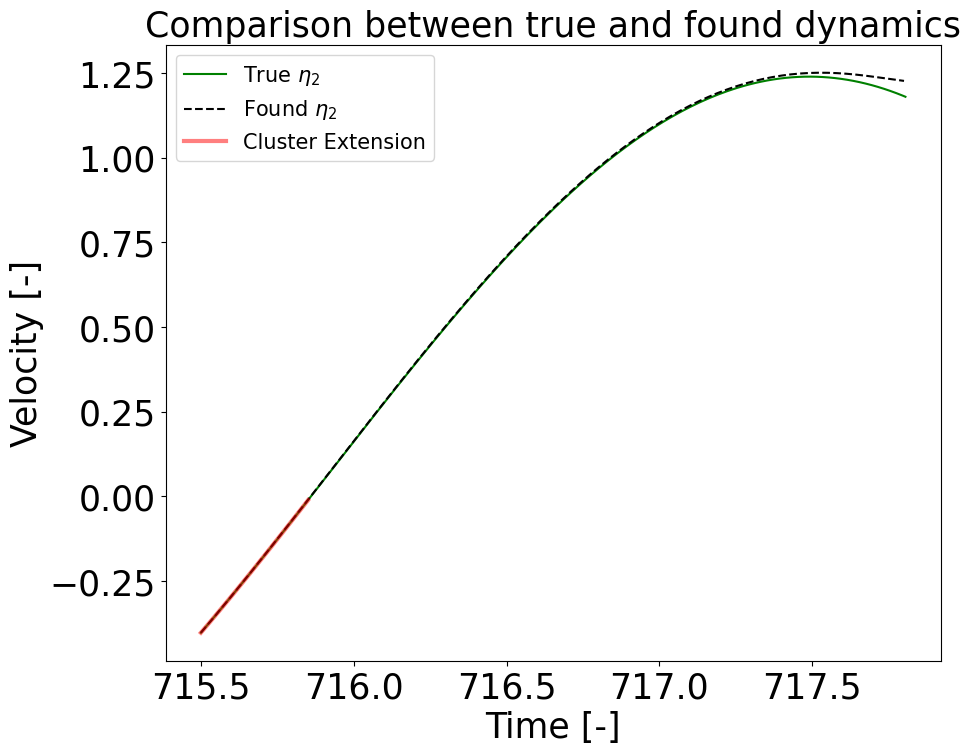

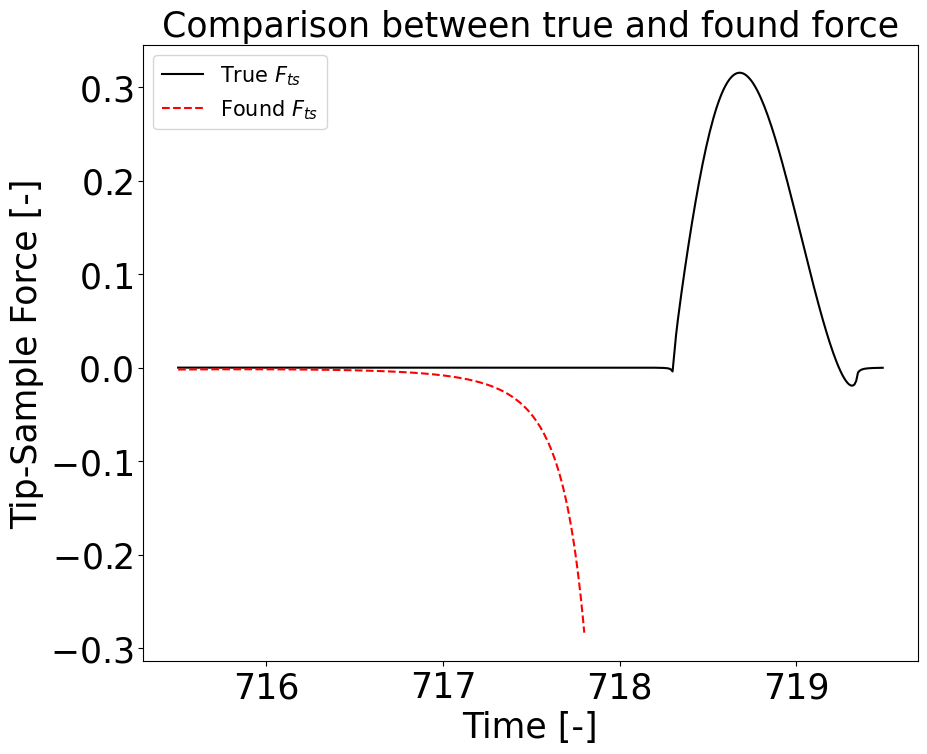

In [60]:
model_to_study = best_rel_AIC_c_C10_df['Candidate Model'][0]
cluster_to_test = 10

simulated_data_C10, extended_val_trajec_C10, F_ts_true_C10, F_ts_sim_C10 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 11

In [61]:
found_models_C11_df = mark_unique_models_in_dataframe(found_models_C11_df)

# Now filter unique models:
unique_models_C11_df = found_models_C11_df[found_models_C11_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C11_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 11

In [62]:
unique_models_to_analyze = unique_models_C11_df
analyzed_cluster = 11

simulated_information_C11, error_information_C11, AIC_models_in_cluster_C11 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C11 = get_relative_AIC_c_score(AIC_models_in_cluster_C11)

unique_models_C11_df['Delta_AIC_c'] = rel_AIC_c_lst_C11

Processing models: 100%|██████████| 100/100 [00:40<00:00,  2.46model/s]


## Best models within Cluster 11

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [63]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C11_df = unique_models_C11_df[unique_models_C11_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C11_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  07-02-25-013-11          11         6  0.00012915496650148828   

                     Nu  Delta_AIC_c  
0  0.046415888336127774          0.0

## Simulation of one of these candidate models for cluster 11

rms was: 6.107026662422452
switch_ind was: 148

Equation with length: 6
(e1)' = 1.000000000 e2
(e2)' = 0.006187404 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.012253418 (1-e1)^-2 + 0.035433374 (1-e1)^-3
(phase)' = 1.000000000 1



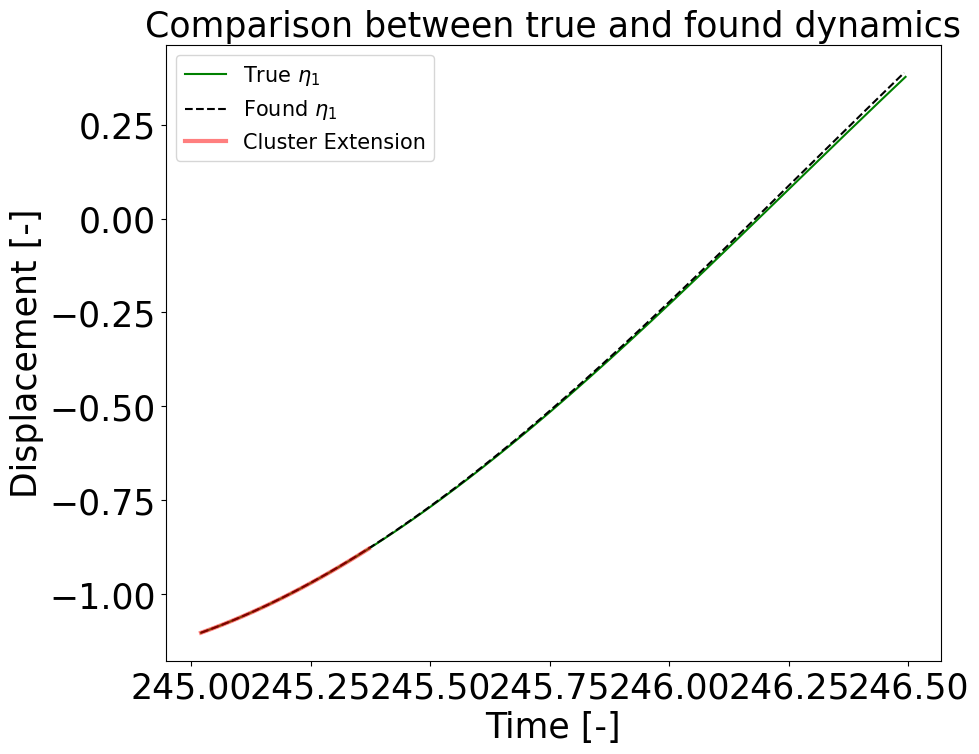

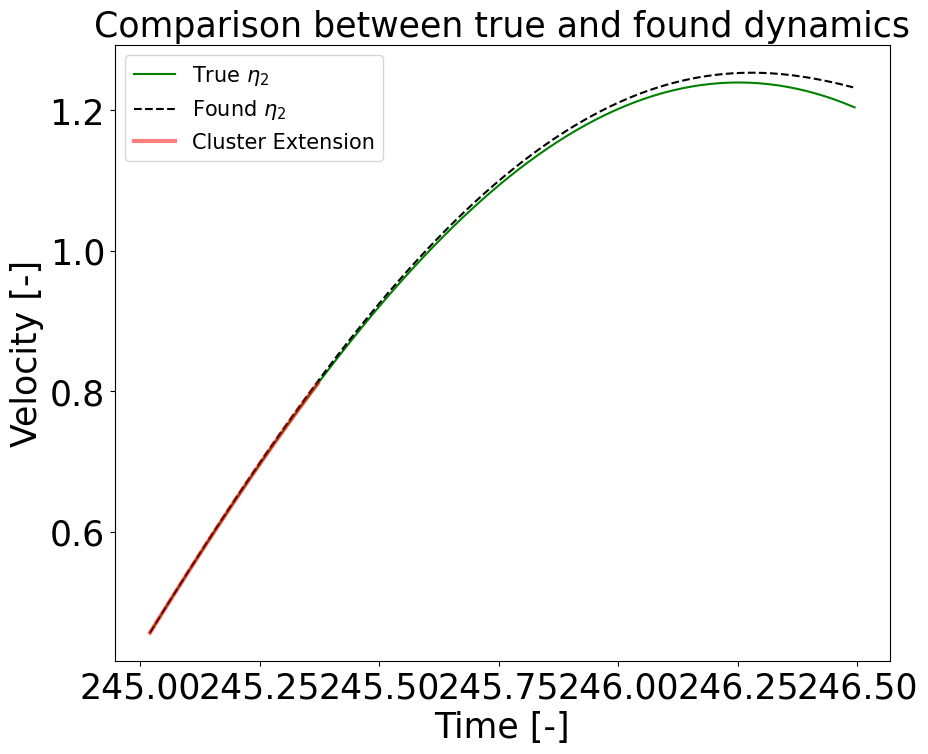

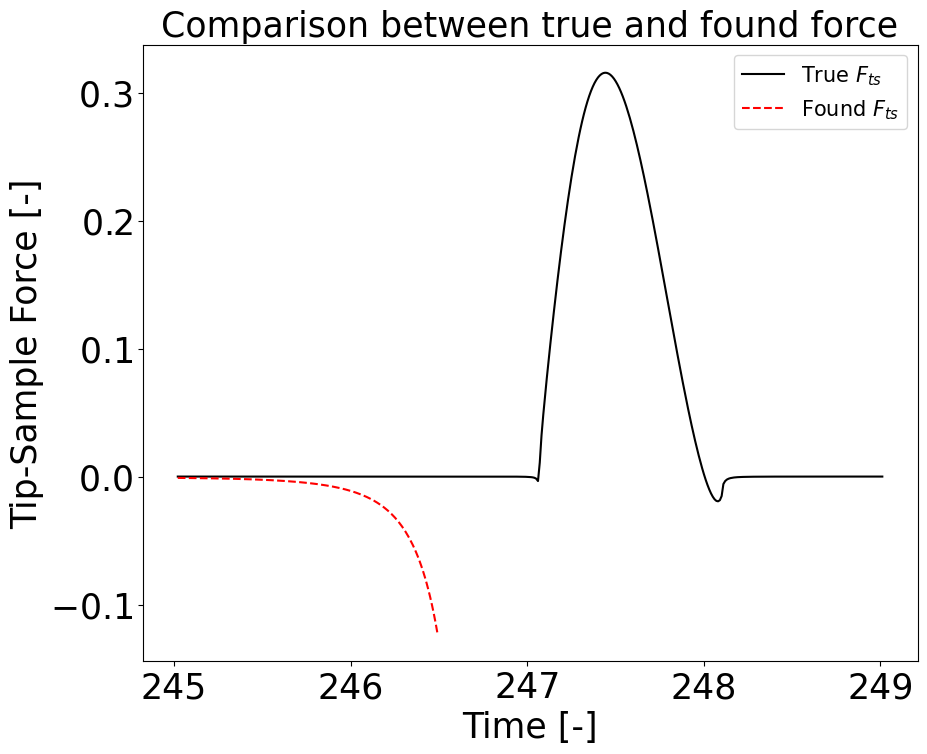

In [64]:
model_to_study = best_rel_AIC_c_C11_df['Candidate Model'][0]
cluster_to_test = 11

simulated_data_C11, extended_val_trajec_C11, F_ts_true_C11, F_ts_sim_C11 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 12

In [65]:
found_models_C12_df = mark_unique_models_in_dataframe(found_models_C12_df)

# Now filter unique models:
unique_models_C12_df = found_models_C12_df[found_models_C12_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C12_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 12

In [66]:
unique_models_to_analyze = unique_models_C12_df
analyzed_cluster = 12

simulated_information_C12, error_information_C12, AIC_models_in_cluster_C12 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-2, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C12 = get_relative_AIC_c_score(AIC_models_in_cluster_C12)

unique_models_C12_df['Delta_AIC_c'] = rel_AIC_c_lst_C12

Processing models: 100%|██████████| 100/100 [00:47<00:00,  2.09model/s]


## Best models within Cluster 12

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [67]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C12_df = unique_models_C12_df[unique_models_C12_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C12_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda                    Nu  \
0  07-02-25-093-12          12        12  1e-07  0.046415888336127774   

   Delta_AIC_c  
0          0.0

## Simulation of one of these candidate models for cluster 12

rms was: 1.080382872143547
switch_ind was: 2

Equation with length: 12
(e1)' = 1.000000000 e2
(e2)' = -1.244267028 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000001245 (1-e1)^-2 + -131.077561480 (0.0132626-1+e1)^1.5 + 78.530705539 (0.0132626-1+e1)^2 + 60.186994784 (0.0132626-1+e1)^2.5 + -0.802786919 ((0.0132626-1+e1)^0.5)*e2^1 + -16.068706489 ((0.0132626-1+e1)^0.5)*e2^2 + 7.896385240 ((0.0132626-1+e1)^1)*e2^1 + 7.691877643 ((0.0132626-1+e1)^1)*e2^2
(phase)' = 1.000000000 1



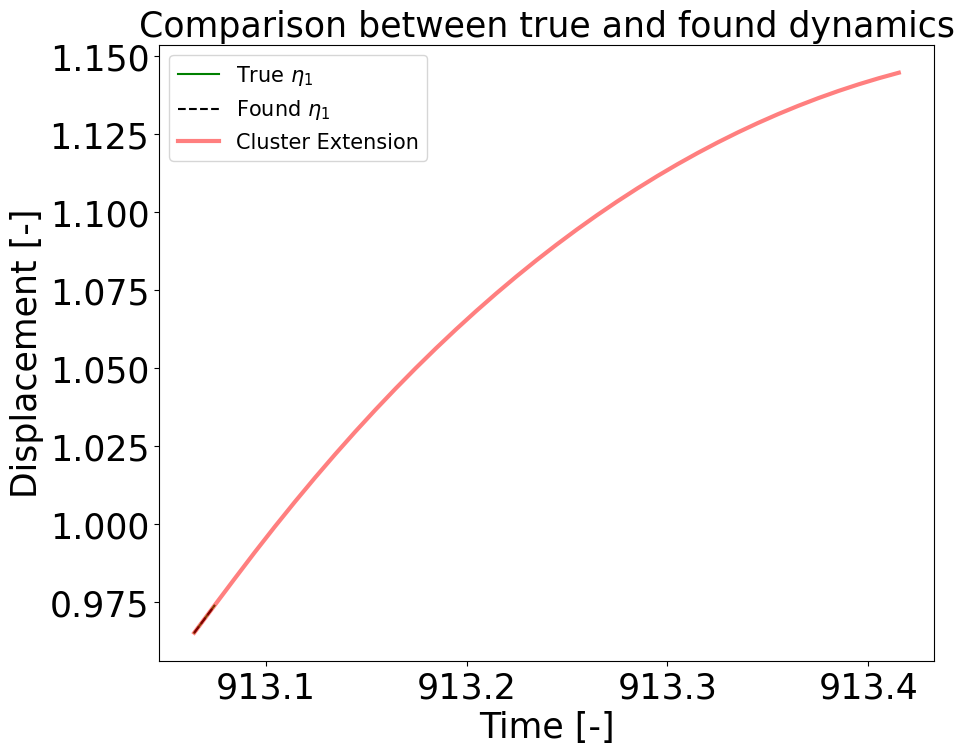

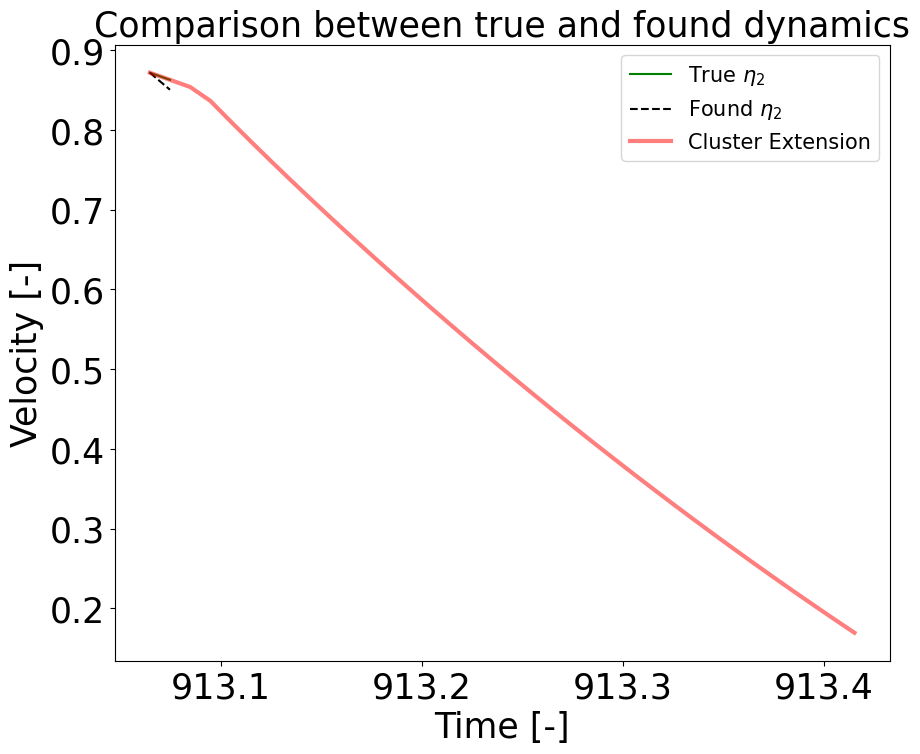

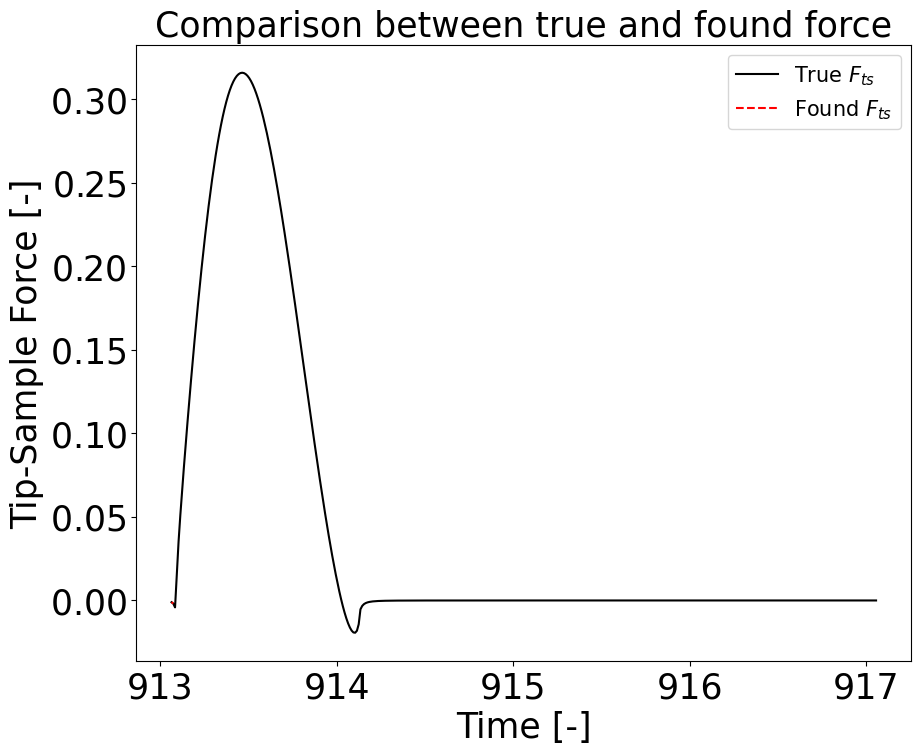

In [68]:
model_to_study = best_rel_AIC_c_C12_df['Candidate Model'][0]
cluster_to_test = 12

simulated_data_C12, extended_val_trajec_C12, F_ts_true_C12, F_ts_sim_C12 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 13

In [69]:
found_models_C13_df = mark_unique_models_in_dataframe(found_models_C13_df)

# Now filter unique models:
unique_models_C13_df = found_models_C13_df[found_models_C13_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C13_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 13

In [70]:
unique_models_to_analyze = unique_models_C13_df
analyzed_cluster = 13

simulated_information_C13, error_information_C13, AIC_models_in_cluster_C13 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C13 = get_relative_AIC_c_score(AIC_models_in_cluster_C13)

unique_models_C13_df['Delta_AIC_c'] = rel_AIC_c_lst_C13

Processing models: 100%|██████████| 100/100 [00:25<00:00,  3.92model/s]


## Best models within Cluster 13

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [71]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C13_df = unique_models_C13_df[unique_models_C13_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C13_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda    Nu  \
0  07-02-25-040-13          13        11  1.6681005372000593e-05  0.01   
1  07-02-25-000-13          13         9                   0.001  0.01   

   Delta_AIC_c  
0     0.597948  
1     0.000000

## Simulation of one of these candidate models for cluster 13

rms was: 0.5854418587239392
switch_ind was: 8

Equation with length: 11
(e1)' = 1.000000000 e2
(e2)' = 0.929424386 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -3.902751948 (0.0132626-1+e1)^1.5 + -3.421731381 (0.0132626-1+e1)^2 + 0.634114605 (0.0132626-1+e1)^2.5 + 0.907416047 ((0.0132626-1+e1)^0.5)*e2^1 + -0.615428055 ((0.0132626-1+e1)^0.5)*e2^2 + 0.466722059 ((0.0132626-1+e1)^1)*e2^1 + -0.747210930 ((0.0132626-1+e1)^1)*e2^2
(phase)' = 1.000000000 1



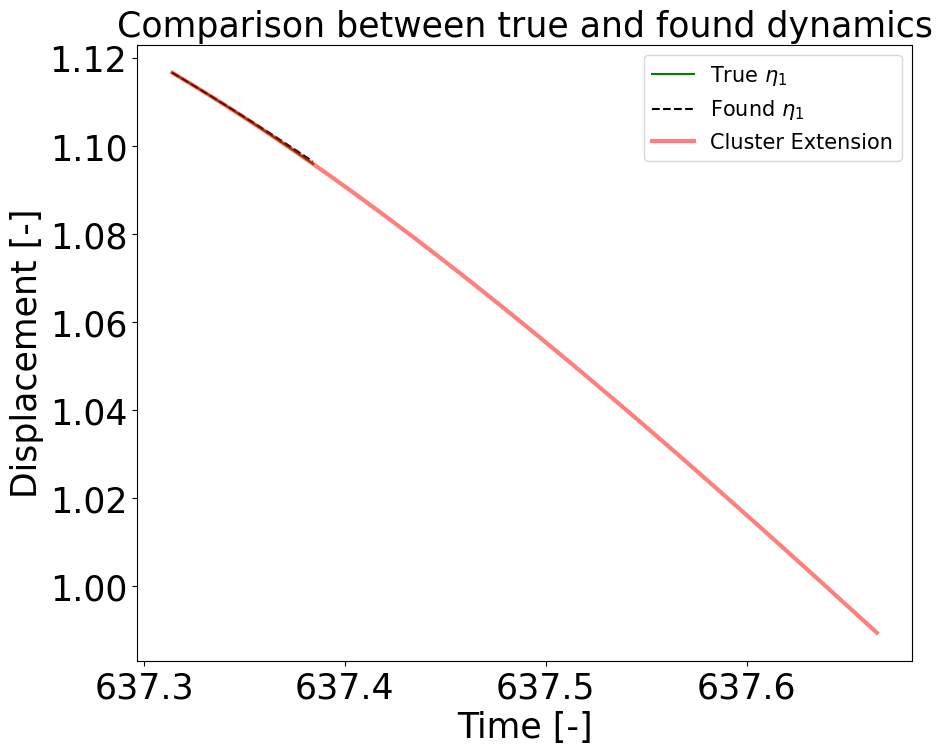

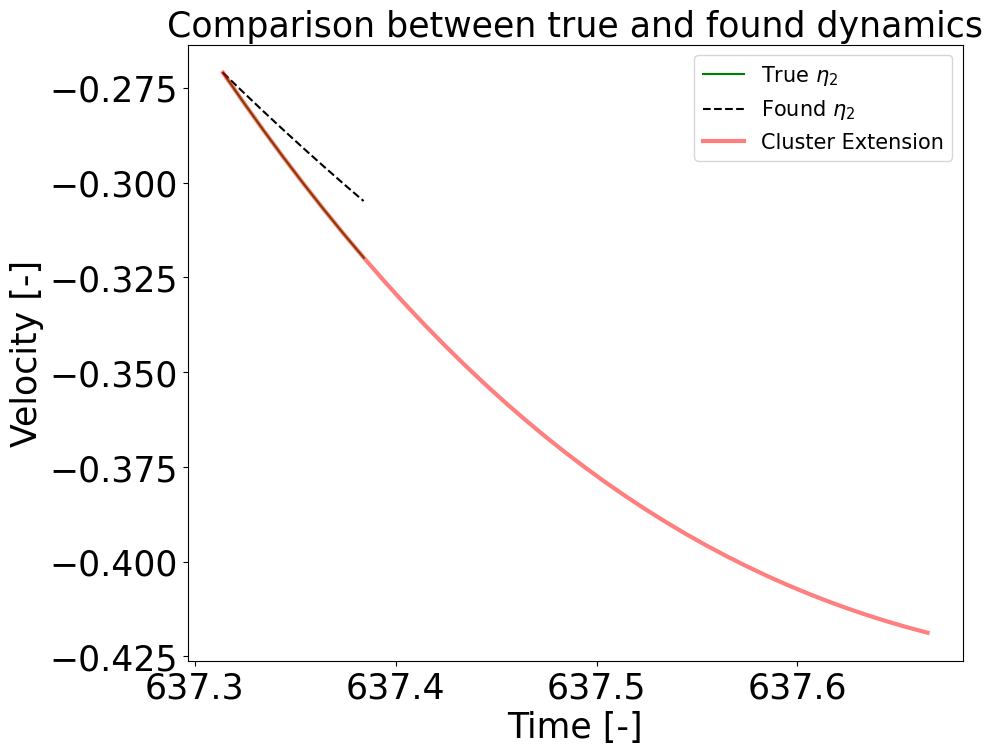

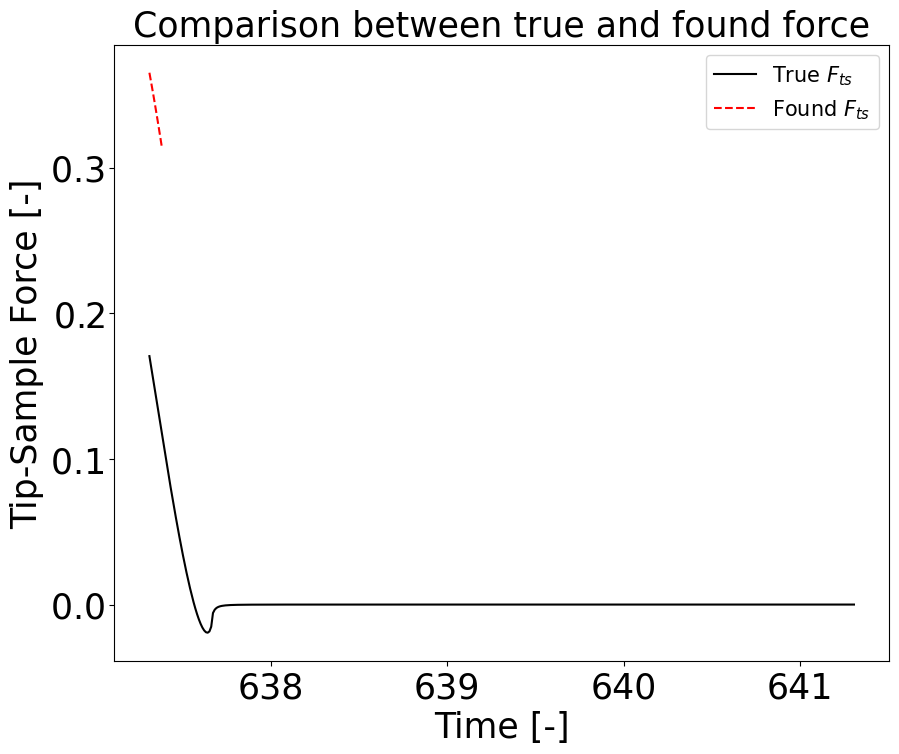

In [72]:
model_to_study = best_rel_AIC_c_C13_df['Candidate Model'][0]
cluster_to_test = 13

simulated_data_C13, extended_val_trajec_C13, F_ts_true_C13, F_ts_sim_C13 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 14

In [73]:
found_models_C14_df = mark_unique_models_in_dataframe(found_models_C14_df)

# Now filter unique models:
unique_models_C14_df = found_models_C14_df[found_models_C14_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C14_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 50 unique models were found



## AIC analysis for all models within one cluster: Cluster 14

In [74]:
unique_models_to_analyze = unique_models_C14_df
analyzed_cluster = 14

simulated_information_C14, error_information_C14, AIC_models_in_cluster_C14 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C14 = get_relative_AIC_c_score(AIC_models_in_cluster_C14)

unique_models_C14_df['Delta_AIC_c'] = rel_AIC_c_lst_C14

Processing models: 100%|██████████| 50/50 [00:11<00:00,  4.39model/s]


## Best models within Cluster 14

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [75]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C14_df = unique_models_C14_df[unique_models_C14_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C14_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony                  Lambda  \
0  07-02-25-010-14          14         3  0.00012915496650148828   
1  08-02-25-061-14          14         4  2.1544346900318822e-06   
2  08-02-25-063-14          14         4  2.1544346900318822e-06   
3  08-02-25-057-14          14         5   5.994842503189409e-06   
4  08-02-25-078-14          14         6   7.742636826811278e-07   
5  08-02-25-072-14          14         6   7.742636826811278e-07   
6  08-02-25-051-14          14         4   5.994842503189409e-06   
7  08-02-25-066-14          14         4  2.1544346900318822e-06   

                     Nu  Delta_AIC_c  
0                  0.01     0.307989  
1  0.016681005372000592     0.322378  
2  0.046415888336127774     0.330948  
3  0.027825594022071243     0.804174  
4  0.021544346900318832     0.000000  
5   0.01291549665014884     0.155471  
6  0.016681005372000592     0.319416  
7   0.05994842503189409     0.328973

## Simulation of one of these candidate models for cluster 14

rms was: 0.0002487947721244482
switch_ind was: 400

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



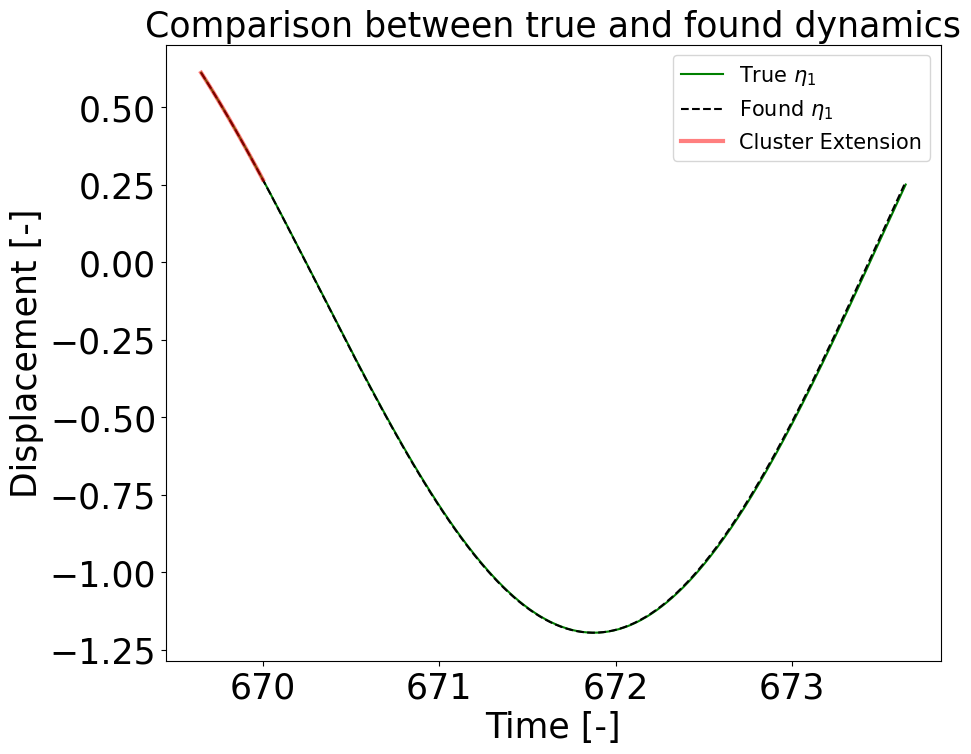

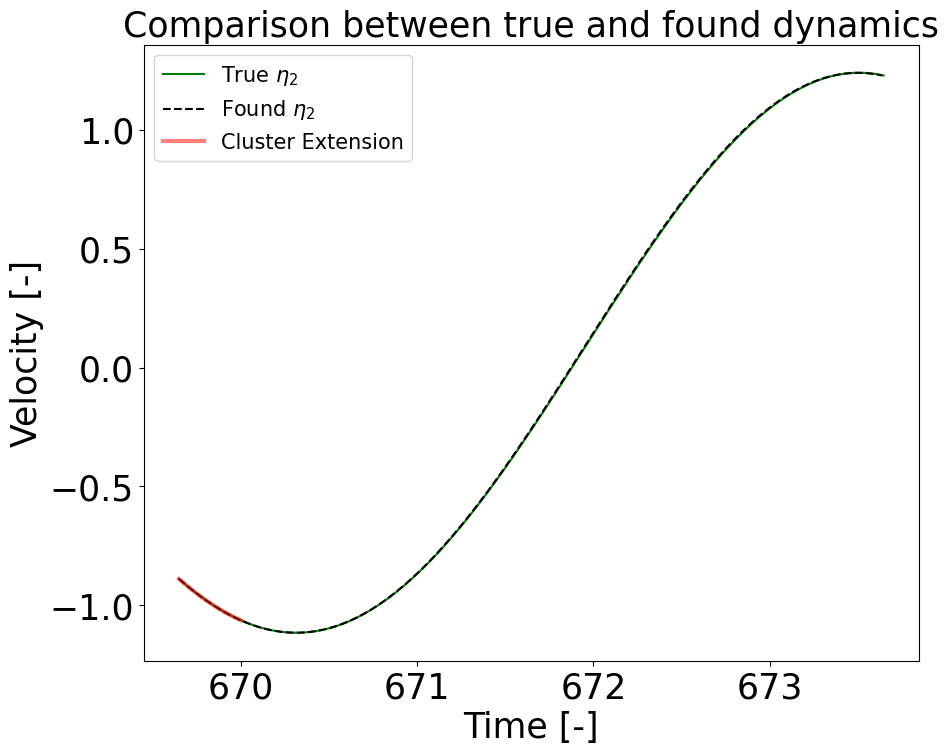

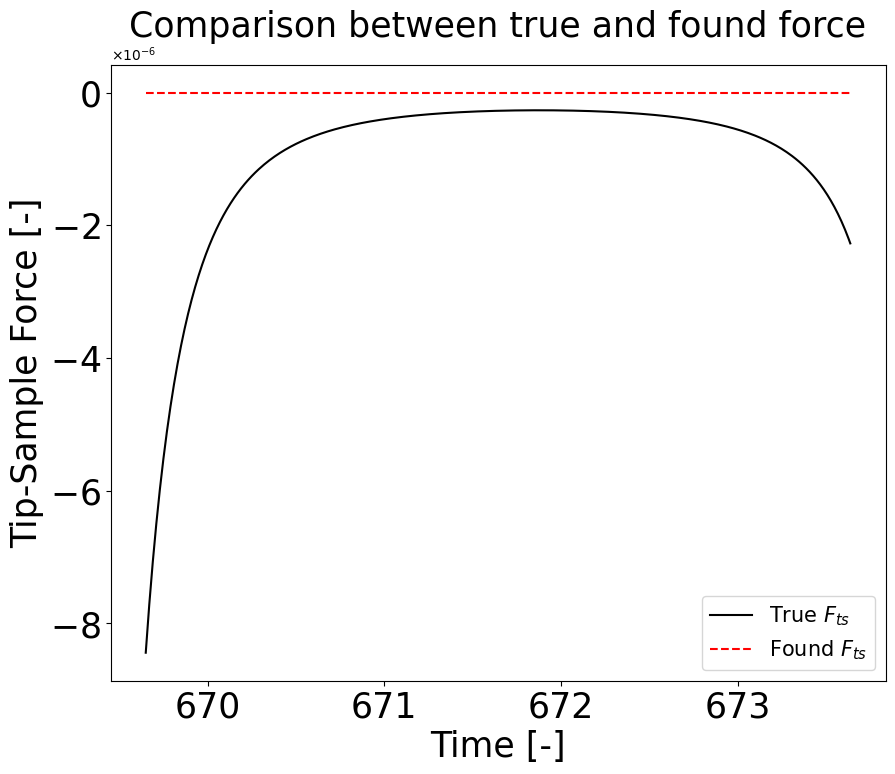

In [76]:
model_to_study = best_rel_AIC_c_C14_df['Candidate Model'][0]
cluster_to_test = 14

simulated_data_C14, extended_val_trajec_C14, F_ts_true_C14, F_ts_sim_C14 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 15

In [77]:
found_models_C15_df = mark_unique_models_in_dataframe(found_models_C15_df)

# Now filter unique models:
unique_models_C15_df = found_models_C15_df[found_models_C15_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C15_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 88 unique models were found



## AIC analysis for all models within one cluster: Cluster 15

In [78]:
unique_models_to_analyze = unique_models_C15_df
analyzed_cluster = 15

simulated_information_C15, error_information_C15, AIC_models_in_cluster_C15 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C15 = get_relative_AIC_c_score(AIC_models_in_cluster_C15)

unique_models_C15_df['Delta_AIC_c'] = rel_AIC_c_lst_C15

Processing models: 100%|██████████| 88/88 [00:25<00:00,  3.42model/s]


## Best models within Cluster 15

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [79]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C15_df = unique_models_C15_df[unique_models_C15_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C15_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda                    Nu  \
0  08-02-25-007-15          15         3  0.001  0.027825594022071243   

   Delta_AIC_c  
0          0.0

## Simulation of one of these candidate models for cluster 15

rms was: 0.01867278255956315
switch_ind was: 395

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



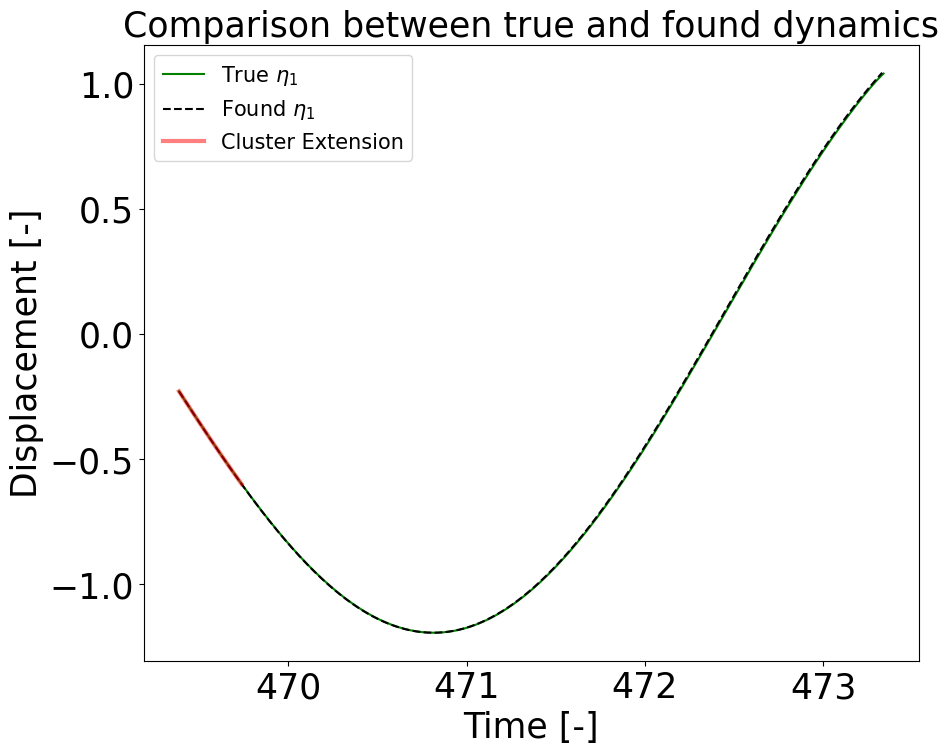

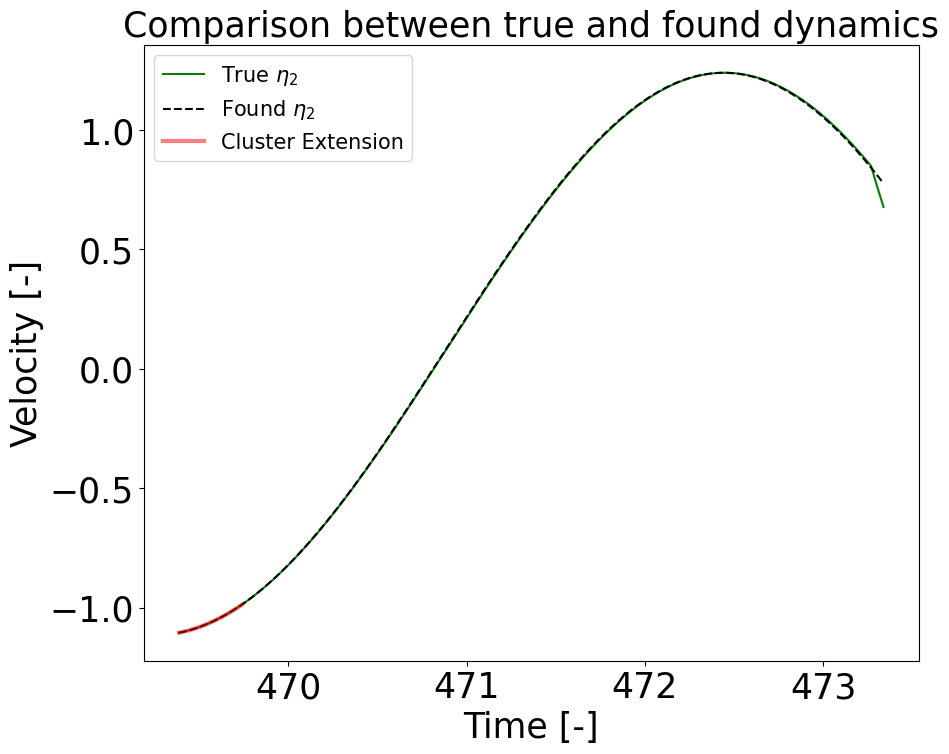

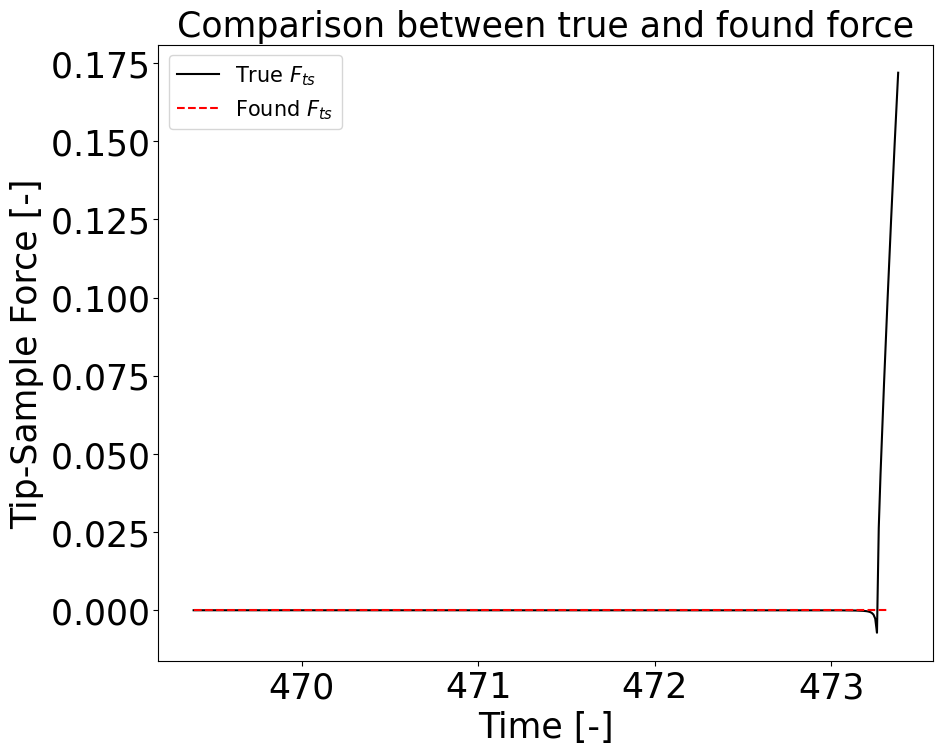

In [80]:
model_to_study = best_rel_AIC_c_C15_df['Candidate Model'][0]
cluster_to_test = 15

simulated_data_C15, extended_val_trajec_C15, F_ts_true_C15, F_ts_sim_C15 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 16

In [81]:
found_models_C16_df = mark_unique_models_in_dataframe(found_models_C16_df)

# Now filter unique models:
unique_models_C16_df = found_models_C16_df[found_models_C16_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C16_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 16

In [82]:
unique_models_to_analyze = unique_models_C16_df
analyzed_cluster = 16

simulated_information_C16, error_information_C16, AIC_models_in_cluster_C16 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-4, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C16 = get_relative_AIC_c_score(AIC_models_in_cluster_C16)

unique_models_C16_df['Delta_AIC_c'] = rel_AIC_c_lst_C16

Processing models: 100%|██████████| 100/100 [00:37<00:00,  2.64model/s]


## Best models within Cluster 16

Here there are the models that have a $\Delta \text{AIC}_c < 1$. Which means that the loss of information is small when simulating the found model. 

In [83]:
# Filter rows where 'Delta AIC_c' is less than 1
best_rel_AIC_c_C16_df = unique_models_C16_df[unique_models_C16_df['Delta_AIC_c'] < 1].reset_index(drop=True)
best_rel_AIC_c_C16_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

Serial No. Cluster No. Parsimony Lambda   Nu  Delta_AIC_c
0  08-02-25-004-16          16         3  0.001  0.1          0.0

## Simulation of one of these candidate models for cluster 16

rms was: 0.1448590616512999
switch_ind was: 315

Equation with length: 3
(e1)' = 1.000000000 e2
(e2)' = -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase)
(phase)' = 1.000000000 1



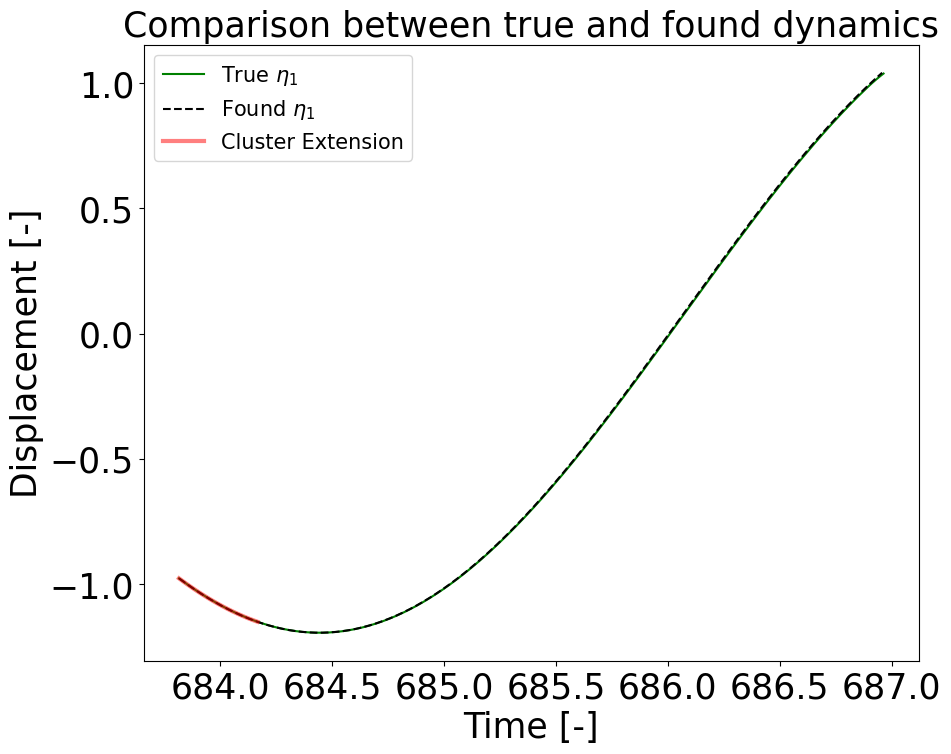

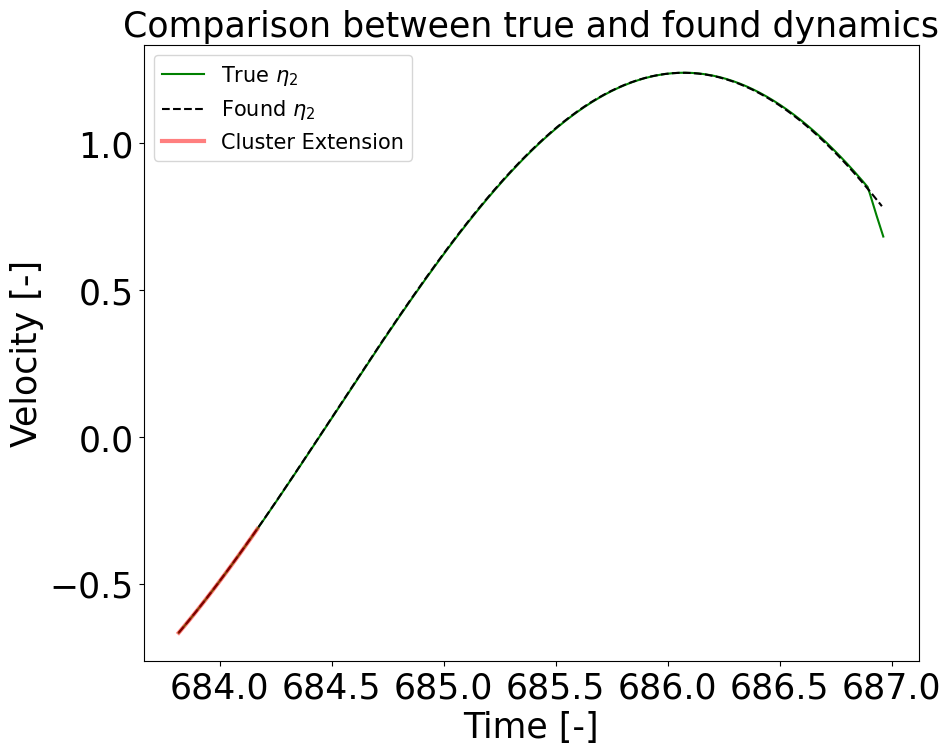

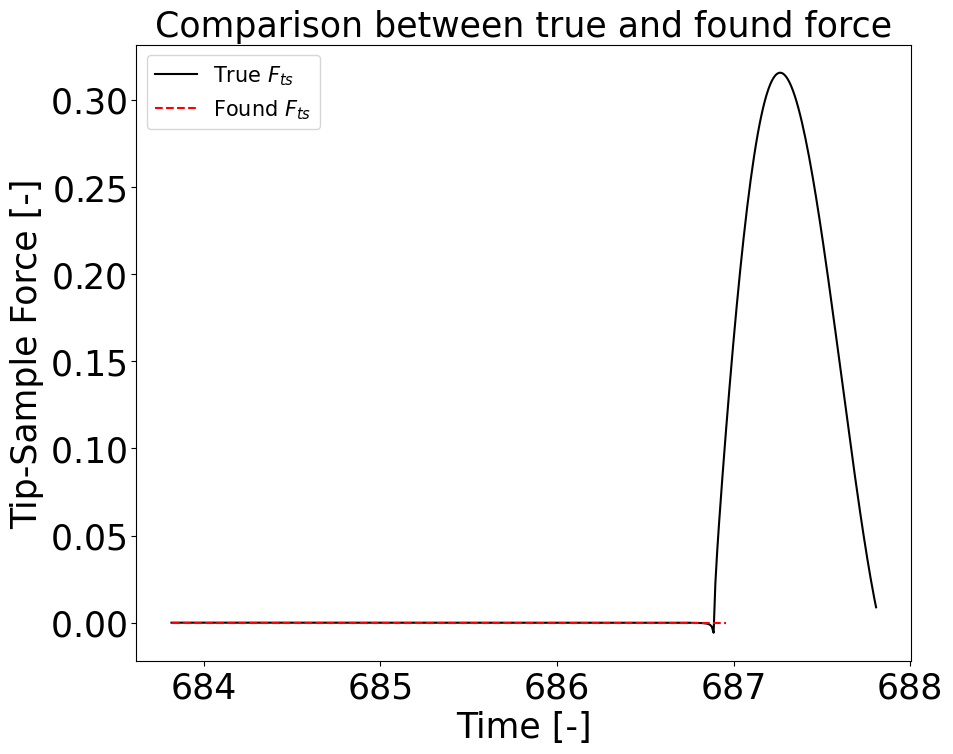

In [84]:
model_to_study = best_rel_AIC_c_C16_df['Candidate Model'][0]
cluster_to_test = 16

simulated_data_C16, extended_val_trajec_C16, F_ts_true_C16, F_ts_sim_C16 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

______________________________________________________________________________________________________________________________________________________________

# Analysis of best models across all clusters

The purpose of this section is to analyze all the best models identified by the $\Delta AIC_{c}$ analysis. To achieve this, the algorithm counts the occurrences of these best models while also remembering their respective clusters. 

## Concatenation of best $\Delta AIC_{c}$ models

Here, the code is grouping or concatenating all the previus dataframes containing only those models which scored a $\Delta AIC_{c} < 1$. Therefore, this dataframe contained the library of best scored candidate models for describing the dynamics of the system. 

In [85]:
# List of the DataFrames
dataframes = [
    best_rel_AIC_c_C0_df,
    best_rel_AIC_c_C1_df,
    best_rel_AIC_c_C2_df,
    best_rel_AIC_c_C3_df,
    best_rel_AIC_c_C4_df,
    best_rel_AIC_c_C5_df,
    best_rel_AIC_c_C6_df,
    best_rel_AIC_c_C7_df,
    best_rel_AIC_c_C8_df,
    best_rel_AIC_c_C9_df,
    best_rel_AIC_c_C10_df,
    best_rel_AIC_c_C11_df,
    best_rel_AIC_c_C12_df,
    best_rel_AIC_c_C13_df,
    best_rel_AIC_c_C14_df,
    best_rel_AIC_c_C15_df,
    best_rel_AIC_c_C16_df
]

# Concatenate all DataFrames into one dataframe containing all best found models. 
best_models_in_all_clusters_df = pd.concat(dataframes, ignore_index=True)

### Found Features extraction from best models in all clusters dataframe

In [86]:
# Add a column for the extracted found candidate functions lists
best_models_in_all_clusters_df['Found Features'] = best_models_in_all_clusters_df['Candidate Model'].apply(extract_active_cand_functions_from_found_eq)

# Count the occurrences of each unique list with found candidate functions
best_models_in_all_clusters_df['Found Features (Tuple)'] = best_models_in_all_clusters_df['Found Features'].apply(tuple)
found_features_counts = best_models_in_all_clusters_df['Found Features (Tuple)'].value_counts()

# Map the counts back to the dataframe using the tuple version of 'Found Features'
best_models_in_all_clusters_df['occurrence'] = best_models_in_all_clusters_df['Found Features (Tuple)'].map(found_features_counts)

### Found Model types with the occurence in the phase space

In [87]:
unique_filtered_df = best_models_in_all_clusters_df.drop_duplicates(subset=['Found Features'])

#Display only unique rows
unique_filtered_df = unique_filtered_df[['Serial No.', 'occurrence', 'Parsimony', 'Found Features']].reset_index(drop=True)

unique_filtered_df

Serial No.  occurrence Parsimony  \
0   04-02-25-045-0          19         6   
1   04-02-25-041-1          37        11   
2   05-02-25-020-2           3         5   
3   05-02-25-067-2          28         5   
4   05-02-25-002-3           6         3   
5   05-02-25-083-4           2         5   
6   05-02-25-009-6           3        10   
7  07-02-25-093-12           1        12   
8  07-02-25-000-13           1         9   
9  08-02-25-061-14           4         4   

                                      Found Features  
0       [1, x0, x1, sin(1*x2), (1-x0)^-2, (1-x0)^-3]  
1  [1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (...  
2          [x0, x1, sin(1*x2), (1-x0)^-2, (1-x0)^-3]  
3                  [1, x0, x1, sin(1*x2), (1-x0)^-2]  
4                                [x0, x1, sin(1*x2)]  
5                  [1, x0, x1, sin(1*x2), (1-x0)^-3]  
6  [1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (...  
7  [1, x0, x1, sin(1*x2), (1-x0)^-2, (0.0132626-1...  
8  [1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (...  
9                             [1, x0, x1, sin(1*x2)]

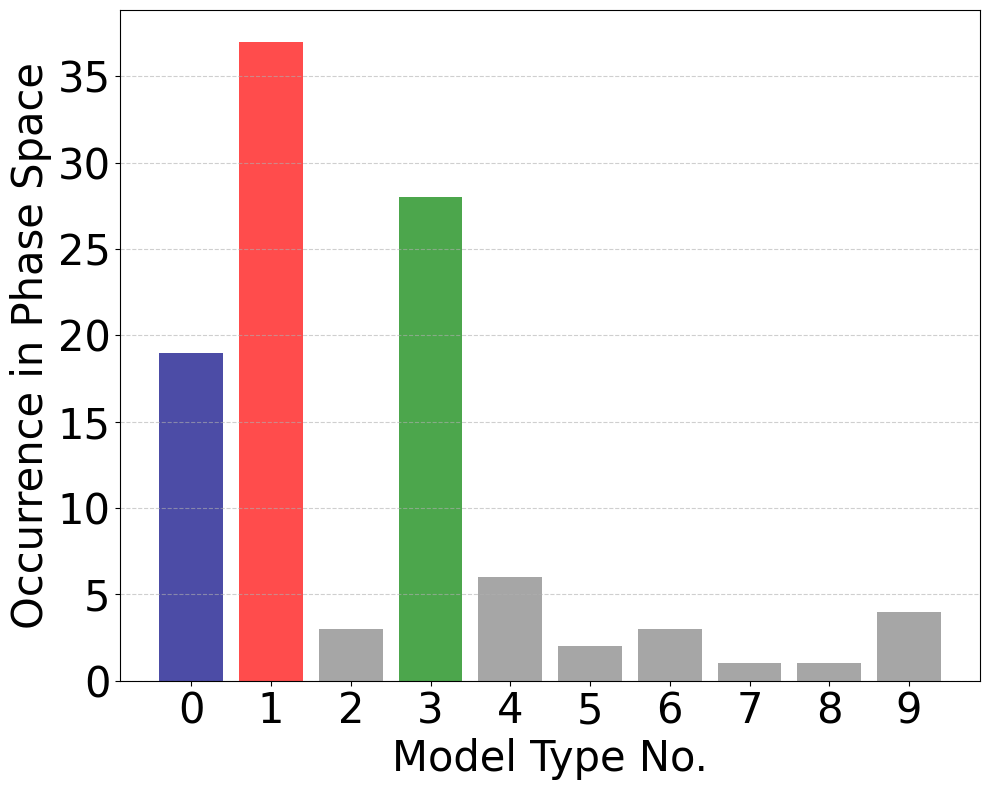

In [88]:
unique_models_test_df = unique_filtered_df

# Predefined color list for occurrences > 2
color_above_2 = ['navy', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Assign colors based on the threshold (>2) without repeating
color_iter = iter(color_above_2)
colors = [
    next(color_iter) if val > 7 else 'grey'
    for val in unique_models_test_df['occurrence']
]

# Create the bar plot
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.bar(unique_models_test_df.index, unique_models_test_df['occurrence'], color=colors, alpha=0.7)

# Add labels and title
plt.xlabel('Model Type No.', fontsize=30)
plt.ylabel('Occurrence in Phase Space', fontsize=30)
x_ticks = range(0, len(unique_models_test_df.index), 1)
axs.set_xticks(x_ticks)
plt.xticks(rotation=0, fontsize=25)
axs.grid(axis='y', linestyle='--', alpha=0.6)
axs.tick_params(axis='both', which='major', labelsize=30)

# Display the plot
plt.tight_layout()

disp_plot_file_name = 'occurance_plot_with_found_features_att_visc_DMT'

# axs.set_title('Library of Most Predominant Model Types \n Across Clusters After $\Delta AIC_{c}$ Analysis', fontsize=25)

# plt.savefig(disp_plot_file_name + '.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Simulation of results of best model types in the Phase Space

rms was: 3.2384094976368796
switch_ind was: 191


'0.000788294 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -0.005384321 (1-e1)^-2 + 0.012356593 (1-e1)^-3'

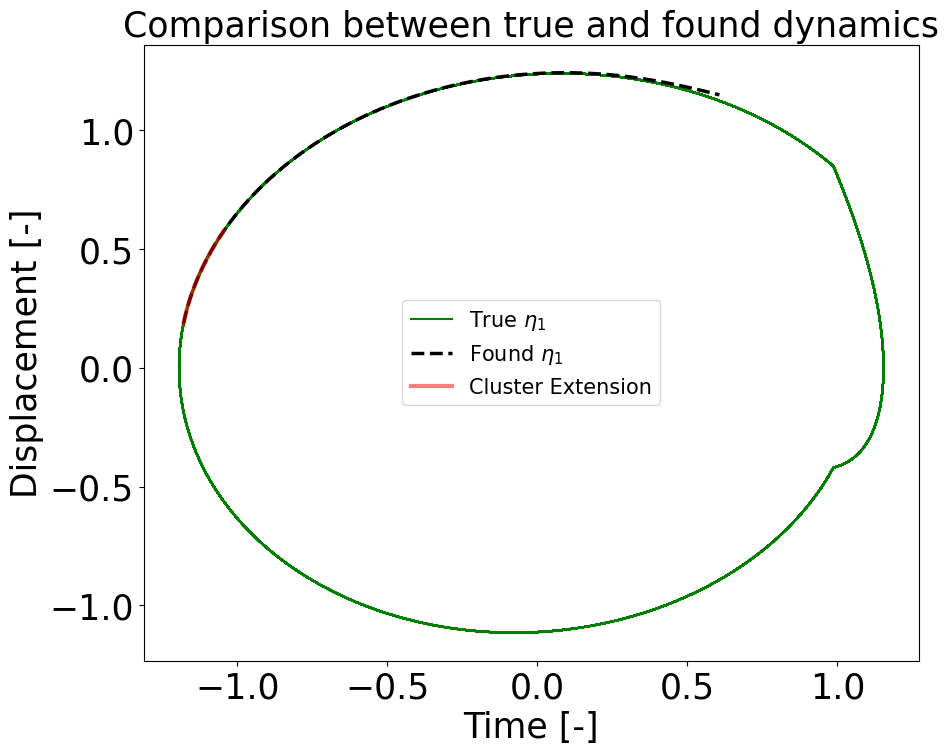

In [90]:
model_to_study = best_rel_AIC_c_C0_df['Candidate Model'][0]
cluster_to_test = 0

simulated_data_C0F, extended_val_trajec_C0F, F_ts_true_C0F, F_ts_sim_C0F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

rms was: 0.0773233368481882
switch_ind was: 52


'-0.042582093 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + -2.890993667 (0.0132626-1+e1)^1.5 + -2.200983726 (0.0132626-1+e1)^2 + -1.637913385 (0.0132626-1+e1)^2.5 + -4.156993156 ((0.0132626-1+e1)^0.5)*e2^1 + 1.110397714 ((0.0132626-1+e1)^0.5)*e2^2 + -1.666843517 ((0.0132626-1+e1)^1)*e2^1 + 0.573831855 ((0.0132626-1+e1)^1)*e2^2'

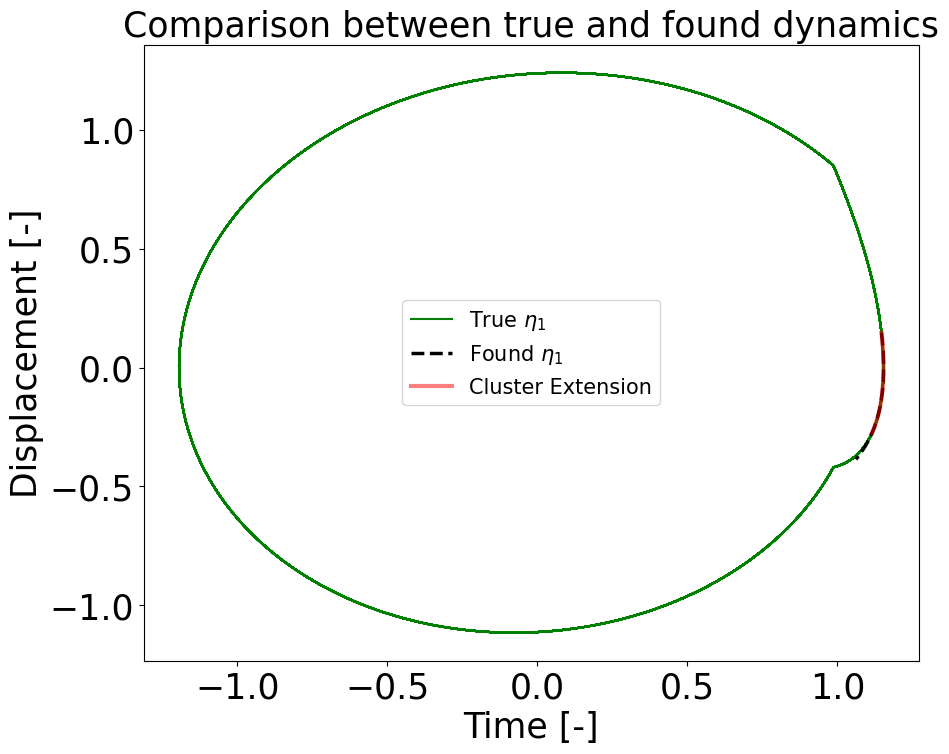

In [91]:
model_to_study = best_rel_AIC_c_C1_df['Candidate Model'][0]
cluster_to_test = 1

simulated_data_C1F, extended_val_trajec_C1F, F_ts_true_C1F, F_ts_sim_C1F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

rms was: 0.13824209386429862
switch_ind was: 526


'0.000009789 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000001347 (1-e1)^-2'

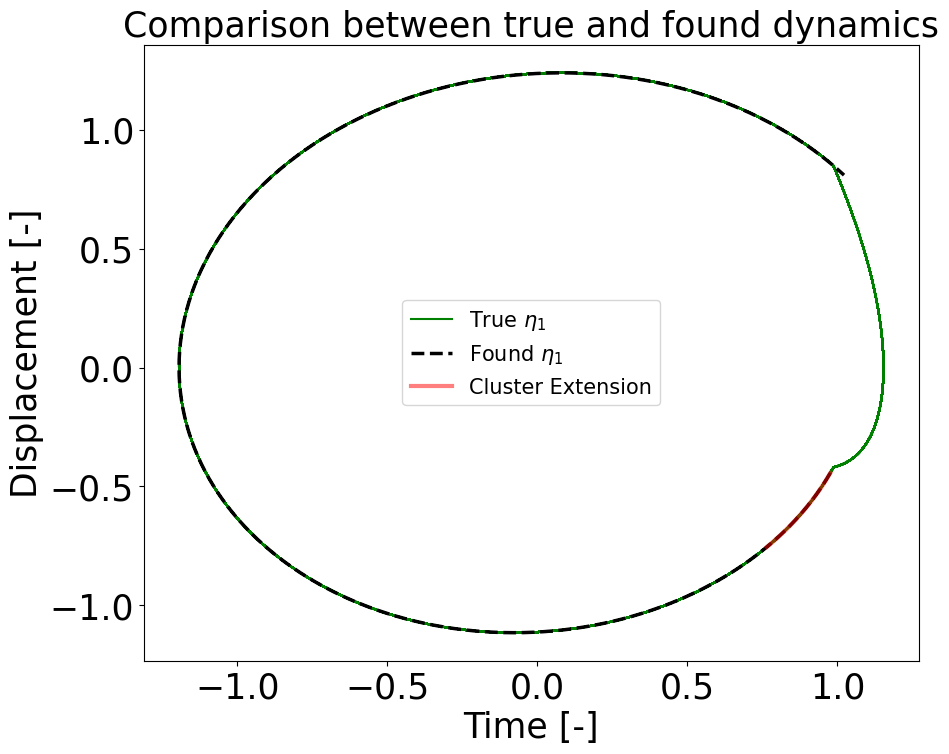

In [92]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][3]
cluster_to_test = 7

simulated_data_C7F, extended_val_trajec_C7F, F_ts_true_C7F, F_ts_sim_C7F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Viscoelastic DMT',#507
                                                 a0=a0, C1=C1, C2=C2, C3=C3, 
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

### Plotting all most prominent found model types

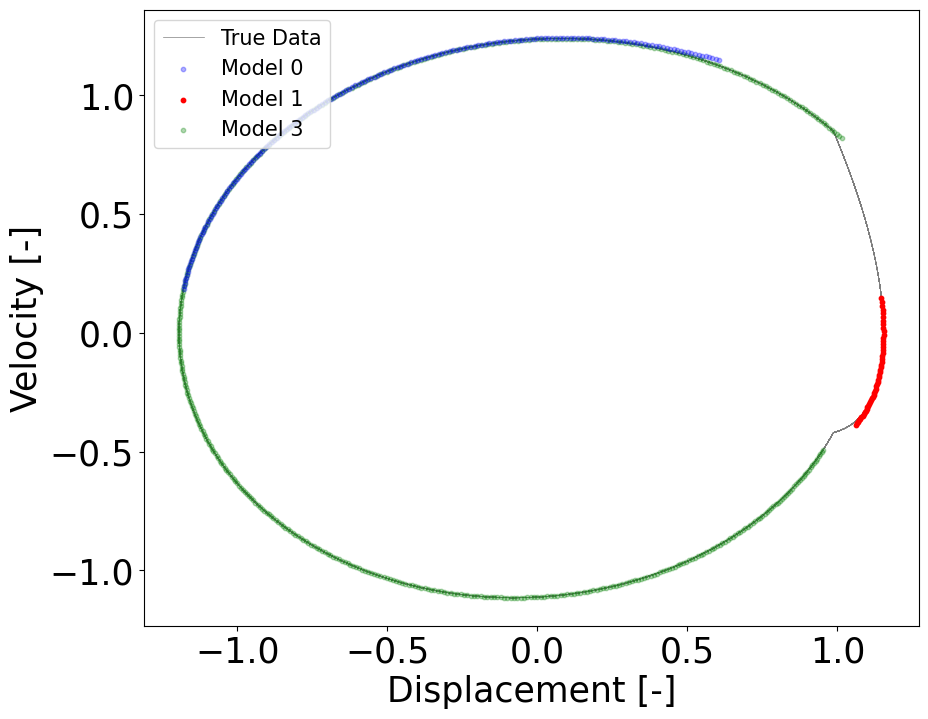

In [ ]:
set_plot_style()

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
# Plot the gray points first with the lowest zorder
axs.plot(x_train_DMT_mult_traj[traject][-16000:,0], x_train_DMT_mult_traj[traject][-16000:,1], color='black', linewidth = 0.5, alpha = 0.5, label = 'True Data', zorder=1)
# Next, plot the other colors with increasing zorder values
axs.scatter(simulated_data_C0F[:, 0], simulated_data_C0F[:, 1], s=10, alpha = 0.3, color = 'blue', label = 'Model 0', zorder=5)
axs.scatter(simulated_data_C1F[:, 0], simulated_data_C1F[:, 1], s=10, color = 'red', label = 'Model 1', zorder=4)
axs.scatter(simulated_data_C7F[5:-1, 0], simulated_data_C7F[5:-1, 1], s=10, alpha = 0.3, color = 'green', label = 'Model 3', zorder=3)

axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=25)
axs.legend(loc='upper left', fontsize=15)
# axs.set_title('AFM DMT Synthetic Data Phase Space with \n Most Predominant Model Types from Training Clusters', fontsize=20)

# Saving the figure with a transparent background
# plt.savefig('viscDMT_phase_space_found_models_simulations_no_title.png', transparent=True, dpi=300, bbox_inches='tight')

## Intermolecular distance

a0 = 0.9867374
Found a0 = 1.0283432
The error in estimating a0 is: 4.0459 %


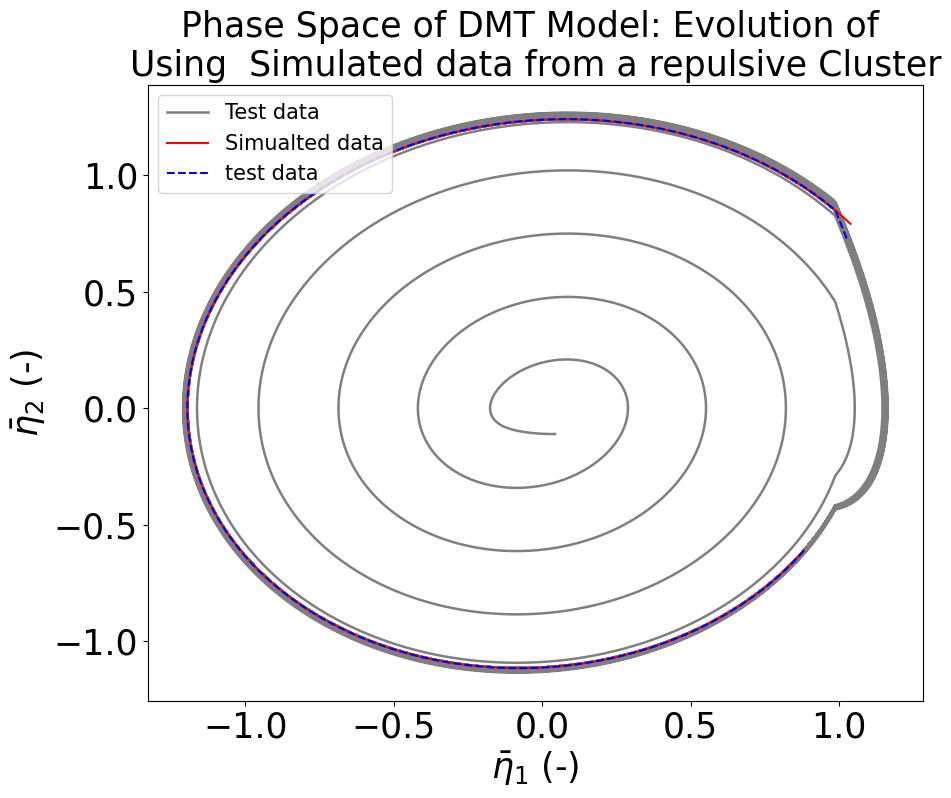

In [95]:
model_to_study = best_rel_AIC_c_C7_df['Candidate Model'][3]
cluster_to_study = 7

test_traject = np.vstack((x_train_DMT_mult_traj[0][:,0], x_train_DMT_mult_traj[0][:,1], x_train_DMT_mult_traj[0][:,2])).T

a0_temp1, a0_temp_list1, a0_estimation_error1, error_list1, sim_found_model, x_test_reg_mult_traj = find_intermolecular_distance(found_SINDy_model=model_to_study, test_trajectory=test_traject, 
                                                                    x_train_synthetic_mult_traj=x_train_DMT_mult_traj, solve_ivp_method = 'BDF',
                                                                    analyzed_cluster = mult_traj_clusters_dots_list[traject][cluster_to_study], error_threshold = ((1e-2)/(2)),#((1e-2)/(2)), 1e-1, ((1e-3)/(1))
                                                                    init_cluster_size = 100, theoretical_a0=a0, plot_results = True, 
                                                                    image_name = 'int_dist_calc_C3', save=False)

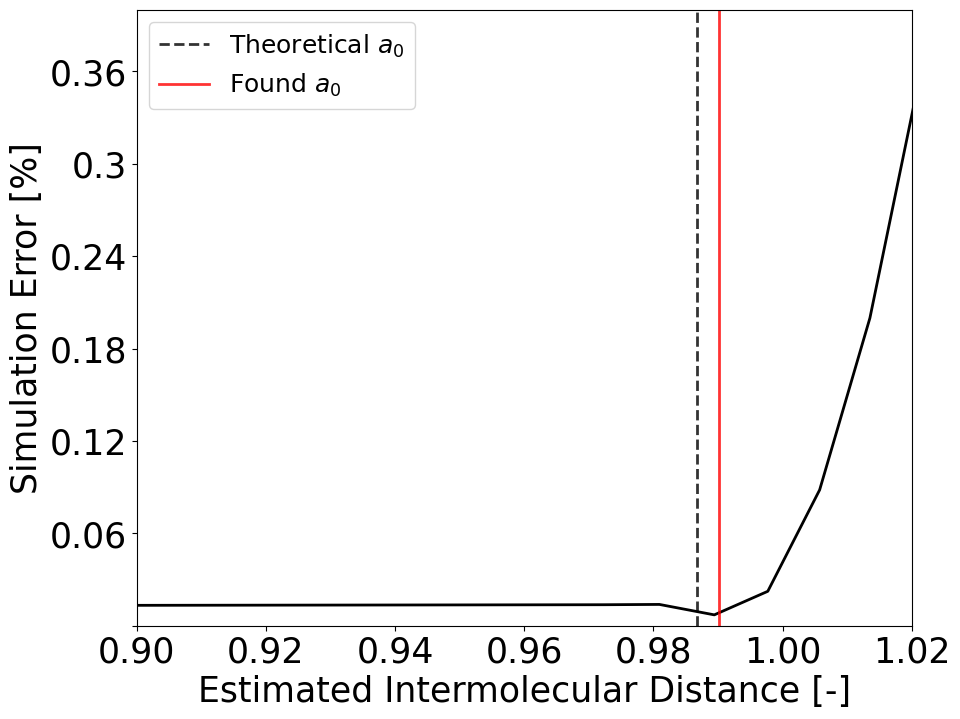

In [96]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

set_plot_style()

errors_percentage = [error * 100 for error in error_list1]

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.plot(a0_temp_list1, errors_percentage, color='black', alpha=1,linewidth=2)
axs.axvline(x=(1-a0), color='black', linestyle='--', label=f'Theoretical $a_0$', alpha=0.8,linewidth=2)
axs.axvline(x=(a0_temp1-(a0+0.025)), color='red', linestyle='-', label=f'Found $a_0$', alpha=0.8,linewidth=2)
axs.set_xlabel('Estimated Intermolecular Distance [-]', fontsize=25)
axs.set_ylabel('Simulation Error [%]', fontsize=25)
axs.xaxis.set_major_locator(MaxNLocator(nbins=7))
axs.yaxis.set_major_locator(MaxNLocator(nbins=7))
axs.legend(loc='upper left')
axs.set_xlim([0.9,1.02])
axs.set_ylim([0,0.4])

axs.set_yticklabels([label if label != 0 else '' for label in axs.get_yticks()]) #removes the zero from the origin of the y axis

# Adding legend and customizing ticks
axs.legend(loc='upper left', fontsize=18)
axs.tick_params(axis='both', which='major', labelsize=25)

# Saving the figure with a transparent background
# plt.savefig('sim_error_vs_intermolecular_dist_from_attractive.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()